In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os

myDir = 'gdrive/My Drive/AAIC_Self_Case_Study_1'
print(os.listdir(myDir))
os.chdir(myDir)

['app_events.csv', 'app_labels.csv', 'events.csv', 'gender_age_test.csv', 'gender_age_train.csv', 'label_categories.csv', 'phone_brand_device_model.csv', 'sample_submission.csv', 'totalytrain', 'totalycv', 'totalCVData', 'totaltrainData', 'totaltestData', 'saved_models', 'eventCVData', 'eventtrainData', 'eventytrain', 'eventycv', 'eventtestData', 'prediction_total_data.csv', 'noEventtrainData', 'noEventytrain', 'noEventCVData', 'noEventtestData', 'noEventycv', 'Xnoev_tr', 'ynoev', 'Xnoev_te', 'yev', 'Xev_tr', 'Xev_te', 'prediction_total_data.zip']


# Modeling

## Importing Required Library Files

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.sparse import csr_matrix, hstack
from collections import Counter
from scipy.stats import entropy
from statistics import mean

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, Normalizer, LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import lightgbm as lgb

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Activation, Dropout, Flatten, PReLU, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adagrad, Adam, Adadelta, Adamax
from keras.utils import np_utils

from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import log_loss

from prettytable import PrettyTable

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing Data Files

In [4]:
print("# Loading Data")
ageGenderTrain = pd.read_csv('gender_age_train.csv', dtype={'device_id':np.str})
ageGenderTest = pd.read_csv('gender_age_test.csv', dtype={'device_id':np.str})
phoneBrand = pd.read_csv('phone_brand_device_model.csv', dtype={'device_id':np.str})
appLabels = pd.read_csv('app_labels.csv', dtype={'app_id':np.str})
eventsData = pd.read_csv('events.csv', parse_dates=['timestamp'], dtype={'device_id':np.str, 'event_id':np.str})
appEventsData = pd.read_csv('app_events.csv', dtype={'app_id':np.str, 'event_id':np.str})
labelCat = pd.read_csv('label_categories.csv', dtype={'category':np.str})
print("# Data Loaded")

# Loading Data
# Data Loaded


# 1. Feature Transformation
Following features are created as part of building a model:
1. **Label Categories**
  1. TFIDF for Label Categories
  2. Total DISTINCT Label Categories present per device
  3. Proportion of Label Categories present on a device TO total no. of Label Categories
2. **Label ID**
  1. TFIDF for Label ID
  2. Total Label IDs present per device 
  3. Proportion of Labels present on a device TO total no. of Labels
  4. Entropy for Label IDs
3. **APP ID**
  1. TFIDF for APP ID
  2. Total APP IDs present per device 
  3. Proportion of APPIDs present on a device TO total no. of APPIDs
  4. Entropy for APP IDs
4. **IS_ACTIVE**
  1. TFIDF for IS_ACTIVE
  2. Entropy for IS_ACTIVE
5. **Phone Brand**
  1. TFIDF for Phone Brand
6. **Device Model**
  1. TFIDF for Device Model
7. **Day of Week**
  1. One Hot Encoding for Day of Week
  2. Entropy for Day of Week
8. **Hour of Day**
  1. One Hot Encoding for Hour of Day
  2. Entropy for Hour of Day
9. **Part of Day**
  1. One Hot Encoding for Part of Day
  2. Entropy for Part of Day
10. **Event Count**
  1. Count of Events per Device
11. **Latitude**
  1. One Hot Encoding for Latitude
12. **Latitude Region**
  1. One Hot Encoding for Latitude Region
13. **Longitude**
  1. One Hot Encoding for Longitude
14. **Longitude Region**
  1. One Hot Encoding for Longitude Region

#### Dropping GENDER and AGE Columns as those are not needed.

In [5]:
ageGenderTrain = ageGenderTrain.drop(['gender', 'age'], axis=1)

print("Train Size:", ageGenderTrain.shape)
print("Test Size:", ageGenderTest.shape)
trainrec = ageGenderTrain.shape[0]
testrec = ageGenderTest.shape[0]
ageGenderTrain.head()

Train Size: (74645, 2)
Test Size: (112071, 1)


,device_id,group
0,-8076087639492063270,M32-38
1,-2897161552818060146,M32-38
2,-8260683887967679142,M32-38
3,-4938849341048082022,M29-31
4,245133531816851882,M29-31


#### Creating a subset of TRAIN-TEST Dataset that have EVENTs records

In [6]:
trainEventData = ageGenderTrain.loc[ageGenderTrain.device_id.isin(eventsData.device_id)]
testEventData = ageGenderTest.loc[ageGenderTest.device_id.isin(eventsData.device_id)]

#### Finding DISTINCT Count of important records

In [7]:
uApps = appLabels.app_id.nunique()
uLabels = appLabels.label_id.nunique()
uBrands = phoneBrand.phone_brand.nunique()
uModels = phoneBrand.device_model.nunique()
uEvents = eventsData.event_id.nunique()
uCats = labelCat.category.nunique()

print(uApps, uLabels, uBrands, uModels, uEvents, uCats)

113211 507 131 1599 3252950 835


#### Defining Functions to Perform TFIDF and Count Vectorization

In [8]:
# REF - https://www.kaggle.com/shahnawazakhtar/using-features-from-label-categories-csv
def vectorize(train, test, columns, fillMissing):
    data = pd.concat((train, test), axis=0, ignore_index=True)
    data = data[columns].astype(np.str).apply(lambda x: " ".join(s for s in x), axis=1).fillna(fillMissing)
    print(data.shape)
    split_len = len(train)

    # TF-IDF Feature
    print("TfidfVectorizer for", columns)
    vectorizer = TfidfVectorizer(min_df=1)
    data = vectorizer.fit_transform(data)

    train = data[:split_len, :]
    test = data[split_len:, :]
    return train, test

In [9]:
def vectorizeOHE(train, test, columns, fillMissing):
    data = pd.concat((train, test), axis=0, ignore_index=True)
    data = data[columns].astype(np.str).apply(lambda x: " ".join(s for s in x), axis=1).fillna(fillMissing)
    print(data.shape)
    split_len = len(train)

    # OHE Feature
    print("One Hot Encoding for", columns)
    vectorizer = CountVectorizer(min_df=1)
    data = vectorizer.fit_transform(data)

    train = data[:split_len, :]
    test = data[split_len:, :]
    return train, test

## 1.1 Handling Label-Categories

### 1.1.1 Mapping Label Categories to Device IDs

In [10]:
print("--Handling Labels Categories")
#---------------------------------------------------------------------------
labelCat = labelCat.fillna('unknown')
labelCat.drop_duplicates(keep='first', inplace=True)
#---------------------------------------------------------------------------
labelCat["category"] = labelCat["category"].apply(lambda x: " ".join(str(x).replace("-"," ").replace("/"," ").replace("("," ").replace(")"," ").split()))
labelCat.category = labelCat.category.apply(lambda x: "Cat:"+str(x))
categories = labelCat.groupby('label_id')['category'].apply(lambda x: " ".join(s for s in x))

labelCat = labelCat.drop('category', axis=1)
#---------------------------------------------------------------------------
print("----APP-LABELS")
appLabels["category"] = appLabels["label_id"].map(categories)
categories = appLabels.groupby("app_id")["category"].apply(lambda x: " ".join(str(s) for s in x))

appLabels = appLabels.drop('category', axis=1)
#---------------------------------------------------------------------------
print("----APP-EVENTS")
appEventsData["category"] = appEventsData["app_id"].map(categories)
categories = appEventsData.groupby("event_id")["category"].apply(lambda x: " ".join(str(s) for s in x))

appEventsData = appEventsData.drop('category', axis=1)
#---------------------------------------------------------------------------
print("----EVENTS")
eventsData["category"] = eventsData["event_id"].map(categories)
categories = eventsData.groupby("device_id")["category"].apply(lambda x: " ".join(str(s) for s in x))

eventsData = eventsData.drop('category', axis=1)
#---------------------------------------------------------------------------
print("----TRAIN-TEST Merge")
#ageGenderTrain["category"] = ageGenderTrain["device_id"].map(categories)
#ageGenderTest["category"] = ageGenderTest["device_id"].map(categories)
trainEventData["category"] = trainEventData["device_id"].map(categories)
testEventData["category"] = testEventData["device_id"].map(categories)

#---------------------------------------------------------------------------
del categories
#---------------------------------------------------------------------------
trainEventData.head()

--Handling Labels Categories
----APP-LABELS
----APP-EVENTS
----EVENTS
----TRAIN-TEST Merge


,device_id,group,category
2,-8260683887967679142,M32-38,Cat:Services 1 Cat:Property Industry 2.0 Cat:I...
11,7477216237379271436,F33-42,Cat:Internet Banking Cat:Services 1 Cat:Proper...
13,6352067998666467520,M32-38,Cat:Property Industry 1.0 Cat:Personal Effecti...
15,1508636020748379883,F27-28,nan nan nan nan Cat:Property Industry 1.0 Cat:...
18,-6876541075223249434,M39+,nan nan nan nan nan nan nan Cat:Property Indus...


### 1.1.2 Finding DISTINCT Category Count

In [11]:
trainEventData['catCnt'] = trainEventData.category.apply(lambda x: list(set(str(x).split('Cat:'))))
#trainEventData.category = trainEventData.catCnt.astype(str)
trainEventData.catCnt = trainEventData.catCnt.str.len()
trainEventData.catCnt = trainEventData.catCnt.fillna(0)

testEventData['catCnt'] = testEventData.category.apply(lambda x: list(set(str(x).split('Cat:'))))
#testEventData.category = testEventData.catCnt.astype(str)
testEventData.catCnt = testEventData.catCnt.str.len()
testEventData.catCnt = testEventData.catCnt.fillna(0)

trainEventData.head()

,device_id,group,category,catCnt
2,-8260683887967679142,M32-38,Cat:Services 1 Cat:Property Industry 2.0 Cat:I...,101
11,7477216237379271436,F33-42,Cat:Internet Banking Cat:Services 1 Cat:Proper...,61
13,6352067998666467520,M32-38,Cat:Property Industry 1.0 Cat:Personal Effecti...,49
15,1508636020748379883,F27-28,nan nan nan nan Cat:Property Industry 1.0 Cat:...,49
18,-6876541075223249434,M39+,nan nan nan nan nan nan nan Cat:Property Indus...,135


### 1.1.3 Standard Scaling Label Category Count

In [12]:
vectorizer=StandardScaler()
vectorizer.fit(trainEventData['catCnt'].values.reshape(-1,1))

Xtr_lCatCnt = vectorizer.transform(trainEventData['catCnt'].values.reshape(-1,1))
Xte_lCatCnt = vectorizer.transform(testEventData['catCnt'].values.reshape(-1,1))

print("Train Category-Count Shape: ",Xtr_lCatCnt.shape)
print("Test Category-Count Shape: ",Xte_lCatCnt.shape)

Train Category-Count Shape:  (23309, 1)
Test Category-Count Shape:  (35194, 1)


### 1.1.4 Finding Proportion of Categories Against Each Device ID TO Unique Category Count

In [13]:
Xtr_catCntProp = ((trainEventData.catCnt)/uCats).values.reshape(-1,1)
Xte_catCntProp = ((testEventData.catCnt)/uCats).values.reshape(-1,1)

print("Train Category-Count Proportion Shape: ",Xtr_catCntProp.shape)
print("Test Category-Count Proportion Shape: ",Xte_catCntProp.shape)

Train Category-Count Proportion Shape:  (23309, 1)
Test Category-Count Proportion Shape:  (35194, 1)


### 1.1.5 TFIDF For Label Category

In [14]:
Xtr_lCatEv, Xte_lCatEv = vectorize(trainEventData, testEventData, ["category"], "missing")
print(Xtr_lCatEv.shape)
print(Xte_lCatEv.shape)

(58503,)
TfidfVectorizer for ['category']
(23309, 493)
(35194, 493)


In [15]:
trainEventData = trainEventData.drop(['category','catCnt'], axis=1)
testEventData = testEventData.drop(['category','catCnt'], axis=1)

## 1.2 Handling Label-ID

### 1.2.1 Mapping Label IDs to Device IDs

In [16]:
print("--Handling Labels IDs")
#---------------------------------------------------------------------------
appLabels.drop_duplicates(keep='first', inplace=True)
#---------------------------------------------------------------------------
print("----APP-LABELS")
appLabels.label_id = appLabels.label_id.apply(lambda x: "Label:"+str(x))
labels = appLabels.groupby("app_id")["label_id"].apply(lambda x: " ".join(str(s) for s in x))

#---------------------------------------------------------------------------
print("----APP-EVENTS")
appEventsData["labels"] = appEventsData["app_id"].map(labels)
labels = appEventsData.groupby("event_id")["labels"].apply(lambda x: " ".join(str(s) for s in x))

appEventsData = appEventsData.drop('labels', axis=1)
#---------------------------------------------------------------------------
print("----EVENTS")
eventsData["labels"] = eventsData["event_id"].map(labels)
labels = eventsData.groupby("device_id")["labels"].apply(lambda x: " ".join(str(s) for s in x))

eventsData = eventsData.drop('labels', axis=1)
#---------------------------------------------------------------------------
print("----TRAIN-TEST Merge")
#ageGenderTrain["labels"] = ageGenderTrain["device_id"].map(labels)
#ageGenderTest["labels"] = ageGenderTest["device_id"].map(labels)
trainEventData["labels"] = trainEventData["device_id"].map(labels)
testEventData["labels"] = testEventData["device_id"].map(labels)

#---------------------------------------------------------------------------
del labels
#---------------------------------------------------------------------------
trainEventData.head()

--Handling Labels IDs
----APP-LABELS
----APP-EVENTS
----EVENTS
----TRAIN-TEST Merge


,device_id,group,labels
2,-8260683887967679142,M32-38,Label:713 Label:704 Label:548 Label:713 Label:...
11,7477216237379271436,F33-42,Label:1012 Label:713 Label:704 Label:548 Label...
13,6352067998666467520,M32-38,Label:549 Label:721 Label:704 Label:302 Label:...
15,1508636020748379883,F27-28,nan nan nan nan Label:549 Label:713 Label:704 ...
18,-6876541075223249434,M39+,nan nan nan nan nan nan nan Label:549 Label:71...


In [17]:
trainEventData['labelCnt'] = trainEventData.labels.str.replace('Label:','')
trainEventData.labelCnt = trainEventData.labelCnt.str.replace(' ',', ')
testEventData['labelCnt'] = testEventData.labels.str.replace('Label:','')
testEventData.labelCnt = testEventData.labelCnt.str.replace(' ',', ')
trainEventData.head()

,device_id,group,labels,labelCnt
2,-8260683887967679142,M32-38,Label:713 Label:704 Label:548 Label:713 Label:...,"713, 704, 548, 713, 704, 548, 163, 158, 551, 5..."
11,7477216237379271436,F33-42,Label:1012 Label:713 Label:704 Label:548 Label...,"1012, 713, 704, 548, 756, 761, 777, 782, 787, ..."
13,6352067998666467520,M32-38,Label:549 Label:721 Label:704 Label:302 Label:...,"549, 721, 704, 302, 303, 548, 183, 713, 704, 5..."
15,1508636020748379883,F27-28,nan nan nan nan Label:549 Label:713 Label:704 ...,"nan, nan, nan, nan, 549, 713, 704, 548, 237, 7..."
18,-6876541075223249434,M39+,nan nan nan nan nan nan nan Label:549 Label:71...,"nan, nan, nan, nan, nan, nan, nan, 549, 710, 7..."


### 1.2.2 Finding DISTINCT Label Count

In [18]:
trainEventData.labelCnt = trainEventData.labelCnt.apply(lambda x: list(set(str(x).split(', '))))
#trainEventData.labels = trainEventData.labelCnt.astype(str)
trainEventData.labelCnt = trainEventData.labelCnt.str.len()

testEventData.labelCnt = testEventData.labelCnt.apply(lambda x: list(set(str(x).split(', '))))
#testEventData.labels = testEventData.labelCnt.astype(str)
testEventData.labelCnt = testEventData.labelCnt.str.len()

trainEventData.head()

,device_id,group,labels,labelCnt
2,-8260683887967679142,M32-38,Label:713 Label:704 Label:548 Label:713 Label:...,105
11,7477216237379271436,F33-42,Label:1012 Label:713 Label:704 Label:548 Label...,62
13,6352067998666467520,M32-38,Label:549 Label:721 Label:704 Label:302 Label:...,49
15,1508636020748379883,F27-28,nan nan nan nan Label:549 Label:713 Label:704 ...,48
18,-6876541075223249434,M39+,nan nan nan nan nan nan nan Label:549 Label:71...,138


### 1.2.3 TFIDF For Label IDs

In [19]:
Xtr_labelEv, Xte_labelEv = vectorize(trainEventData, testEventData, ["labels"], "missing")
print(Xtr_labelEv.shape)
print(Xte_labelEv.shape)

(58503,)
TfidfVectorizer for ['labels']
(23309, 487)
(35194, 487)


### 1.2.4 Standard Scaling Label Count

In [20]:
vectorizer=StandardScaler()
vectorizer.fit(trainEventData['labelCnt'].values.reshape(-1,1))

Xtr_labelCnt = vectorizer.transform(trainEventData['labelCnt'].values.reshape(-1,1))
Xte_labelCnt = vectorizer.transform(testEventData['labelCnt'].values.reshape(-1,1))

print("Train Label-Count Shape: ",Xtr_labelCnt.shape)
print("Test Label-Count Shape: ",Xte_labelCnt.shape)

Train Label-Count Shape:  (23309, 1)
Test Label-Count Shape:  (35194, 1)


### 1.2.5 Finding Proportion of Labels Against Each Device ID TO Unique Label Count

In [21]:
Xtr_labelCntProp = ((trainEventData.labelCnt)/uLabels).values.reshape(-1,1)
Xte_labelCntProp = ((testEventData.labelCnt)/uLabels).values.reshape(-1,1)

print("Train Label-Count Proportion Shape: ",Xtr_labelCnt.shape)
print("Test Label-Count Proportion Shape: ",Xte_labelCnt.shape)

Train Label-Count Proportion Shape:  (23309, 1)
Test Label-Count Proportion Shape:  (35194, 1)


### 1.2.6 Calculating ENTROPY for Label-ID

In [22]:
# REF - https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424
trainEventData.labels = trainEventData.labels.apply(lambda x: entropy(list(Counter(str(x).split('Label:')).values()), base=2))
testEventData.labels = testEventData.labels.apply(lambda x: entropy(list(Counter(str(x).split('Label:')).values()), base=2))

print(trainEventData.shape)
print(testEventData.shape)
trainEventData.head()

(23309, 4)
(35194, 3)


,device_id,group,labels,labelCnt
2,-8260683887967679142,M32-38,5.725513,105
11,7477216237379271436,F33-42,5.127119,62
13,6352067998666467520,M32-38,5.055764,49
15,1508636020748379883,F27-28,4.787747,48
18,-6876541075223249434,M39+,5.740114,138


In [23]:
Xtr_labelEntropy = trainEventData['labels'].values.reshape(-1,1)
Xte_labelEntropy = testEventData['labels'].values.reshape(-1,1)

print("Train Label Entropy Shape: ",Xtr_labelEntropy.shape)
print("Test Label Entropy Shape: ",Xte_labelEntropy.shape)

Train Label Entropy Shape:  (23309, 1)
Test Label Entropy Shape:  (35194, 1)


In [24]:
trainEventData = trainEventData.drop(['labels','labelCnt'], axis=1)
testEventData = testEventData.drop(['labels','labelCnt'], axis=1)

## 1.3 Handling App-ID

### 1.3.1 Mapping APP IDs to Device IDs

In [25]:
print("--Handling APP IDs")
#---------------------------------------------------------------------------
labelap = LabelEncoder().fit(appLabels.app_id)
appLabels.app_id = labelap.transform(appLabels.app_id)
appCount = len(labelap.classes_)
print('Total unique apps: ', appCount)

appEventsData.app_id = labelap.transform(appEventsData.app_id)
#---------------------------------------------------------------------------
print("----APP-EVENTS")
appEventsData["appID"] = appEventsData.app_id.astype(str).apply(lambda x: "APPID:"+str(x))
appIDs = appEventsData.groupby("event_id")["appID"].apply(lambda x: " ".join(str(s) for s in x))

appEventsData = appEventsData.drop('appID', axis=1)
#---------------------------------------------------------------------------
print("----EVENTS")
eventsData["appID"] = eventsData["event_id"].map(appIDs)
appIDs = eventsData.groupby("device_id")["appID"].apply(lambda x: " ".join(str(s) for s in x))

eventsData = eventsData.drop('appID', axis=1)
#---------------------------------------------------------------------------
print("----TRAIN-TEST Merge")
#ageGenderTrain["appID"] = ageGenderTrain["device_id"].map(appIDs)
#ageGenderTest["appID"] = ageGenderTest["device_id"].map(appIDs)
trainEventData["appID"] = trainEventData["device_id"].map(appIDs)
testEventData["appID"] = testEventData["device_id"].map(appIDs)

#---------------------------------------------------------------------------
del appIDs
#---------------------------------------------------------------------------
trainEventData.head()

--Handling APP IDs
Total unique apps:  113211
----APP-EVENTS
----EVENTS
----TRAIN-TEST Merge


,device_id,group,appID
2,-8260683887967679142,M32-38,APPID:77971 APPID:21010 APPID:91278 APPID:5192...
11,7477216237379271436,F33-42,APPID:78124 APPID:64724 APPID:90871 APPID:6850...
13,6352067998666467520,M32-38,APPID:43729 APPID:90871 APPID:88212 APPID:7253...
15,1508636020748379883,F27-28,nan nan nan nan APPID:107890 APPID:109184 APPI...
18,-6876541075223249434,M39+,nan nan nan nan nan nan nan APPID:88212 APPID:...


In [26]:
trainEventData['appIDCnt'] = trainEventData.appID.str.replace('APPID:','')
trainEventData.appIDCnt = trainEventData.appIDCnt.str.replace(' ',', ')
testEventData['appIDCnt'] = testEventData.appID.str.replace('APPID:','')
testEventData.appIDCnt = testEventData.appIDCnt.str.replace(' ',', ')
trainEventData.head()

,device_id,group,appID,appIDCnt
2,-8260683887967679142,M32-38,APPID:77971 APPID:21010 APPID:91278 APPID:5192...,"77971, 21010, 91278, 51921, 109792, 68073, 105..."
11,7477216237379271436,F33-42,APPID:78124 APPID:64724 APPID:90871 APPID:6850...,"78124, 64724, 90871, 68509, 88212, 72538, 7332..."
13,6352067998666467520,M32-38,APPID:43729 APPID:90871 APPID:88212 APPID:7253...,"43729, 90871, 88212, 72538, 19975, 109189, 459..."
15,1508636020748379883,F27-28,nan nan nan nan APPID:107890 APPID:109184 APPI...,"nan, nan, nan, nan, 107890, 109184, 90871, 882..."
18,-6876541075223249434,M39+,nan nan nan nan nan nan nan APPID:88212 APPID:...,"nan, nan, nan, nan, nan, nan, nan, 88212, 5562..."


### 1.3.2 Finding DISTINCT APPID Count

In [27]:
trainEventData.appIDCnt = trainEventData.appIDCnt.apply(lambda x: list(set(str(x).split(', '))))
#trainEventData.appID = trainEventData.appIDCnt.astype(str)
trainEventData.appIDCnt = trainEventData.appIDCnt.str.len()

testEventData.appIDCnt = testEventData.appIDCnt.apply(lambda x: list(set(str(x).split(', '))))
#testEventData.appID = testEventData.appIDCnt.astype(str)
testEventData.appIDCnt = testEventData.appIDCnt.str.len()

trainEventData.head()

,device_id,group,appID,appIDCnt
2,-8260683887967679142,M32-38,APPID:77971 APPID:21010 APPID:91278 APPID:5192...,53
11,7477216237379271436,F33-42,APPID:78124 APPID:64724 APPID:90871 APPID:6850...,31
13,6352067998666467520,M32-38,APPID:43729 APPID:90871 APPID:88212 APPID:7253...,20
15,1508636020748379883,F27-28,nan nan nan nan APPID:107890 APPID:109184 APPI...,25
18,-6876541075223249434,M39+,nan nan nan nan nan nan nan APPID:88212 APPID:...,97


### 1.3.3 TFIDF For APP IDs

In [28]:
Xtr_appIDEv, Xte_appIDEv = vectorize(trainEventData, testEventData, ["appID"], "missing")
print(Xtr_appIDEv.shape)
print(Xte_appIDEv.shape)

(58503,)
TfidfVectorizer for ['appID']
(23309, 18888)
(35194, 18888)


### 1.3.4 Standard Scaling APPID Count

In [29]:
vectorizer=StandardScaler()
vectorizer.fit(trainEventData['appIDCnt'].values.reshape(-1,1))

Xtr_appIDCnt = vectorizer.transform(trainEventData['appIDCnt'].values.reshape(-1,1))
Xte_appIDCnt = vectorizer.transform(testEventData['appIDCnt'].values.reshape(-1,1))

print("Train APPID-Count Shape: ",Xtr_appIDCnt.shape)
print("Test APPID-Count Shape: ",Xte_appIDCnt.shape)

Train APPID-Count Shape:  (23309, 1)
Test APPID-Count Shape:  (35194, 1)


### 1.3.5 Finding Proportion of APPs Against Each Device ID TO Unique APPID Count

In [30]:
Xtr_appIDCntProp = ((trainEventData.appIDCnt)/uApps).values.reshape(-1,1)
Xte_appIDCntProp = ((testEventData.appIDCnt)/uApps).values.reshape(-1,1)

print("Train APP ID Proportion Shape: ",Xtr_appIDCntProp.shape)
print("Test APP ID Proportion Shape: ",Xte_appIDCntProp.shape)

Train APP ID Proportion Shape:  (23309, 1)
Test APP ID Proportion Shape:  (35194, 1)


### 1.3.6 Calculating ENTROPY for App-ID

In [31]:
# REF - https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424
trainEventData.appID = trainEventData.appID.apply(lambda x: entropy(list(Counter(str(x).split(', ')).values()), base=2))
testEventData.appID = testEventData.appID.apply(lambda x: entropy(list(Counter(str(x).split(', ')).values()), base=2))

print(trainEventData.shape)
print(testEventData.shape)
trainEventData.head()

(23309, 4)
(35194, 3)


,device_id,group,appID,appIDCnt
2,-8260683887967679142,M32-38,0.0,53
11,7477216237379271436,F33-42,0.0,31
13,6352067998666467520,M32-38,0.0,20
15,1508636020748379883,F27-28,0.0,25
18,-6876541075223249434,M39+,0.0,97


In [32]:
Xtr_appIDEntropy = trainEventData['appID'].values.reshape(-1,1)
Xte_appIDEntropy = testEventData['appID'].values.reshape(-1,1)

print("Train APP ID Entropy Shape: ",Xtr_appIDEntropy.shape)
print("Test APP ID Entropy Shape: ",Xte_appIDEntropy.shape)

Train APP ID Entropy Shape:  (23309, 1)
Test APP ID Entropy Shape:  (35194, 1)


In [33]:
trainEventData = trainEventData.drop(['appID','appIDCnt'], axis=1)
testEventData = testEventData.drop(['appID','appIDCnt'], axis=1)

## 1.4 Handling IS_ACTIVE

### 1.4.1 Mapping IS_ACTIVE to Device IDs

In [34]:
print("--Handling IS_ACTIVE")
#---------------------------------------------------------------------------
print("----APP-EVENTS")
appEventsData["activeApp"] = appEventsData.is_active.astype(str).apply(lambda x: " ".join(str(s) for s in x))
activeApps = appEventsData.groupby("event_id")["is_active"].apply(lambda x: " ".join(str(s) for s in x))

appEventsData = appEventsData.drop('activeApp', axis=1)
#---------------------------------------------------------------------------
print("----EVENTS")
eventsData["activeApp"] = eventsData["event_id"].map(activeApps)
activeApps = eventsData.groupby("device_id")["activeApp"].apply(lambda x: " ".join(str(s) for s in x))

eventsData = eventsData.drop('activeApp', axis=1)
#---------------------------------------------------------------------------
print("----TRAIN-TEST Merge")
#ageGenderTrain["activeApp"] = ageGenderTrain["device_id"].map(activeApps)
#ageGenderTest["activeApp"] = ageGenderTest["device_id"].map(activeApps)

trainEventData["activeApp"] = trainEventData["device_id"].map(activeApps)
testEventData["activeApp"] = testEventData["device_id"].map(activeApps)

del activeApps
#---------------------------------------------------------------------------
trainEventData.head()

--Handling IS_ACTIVE
----APP-EVENTS
----EVENTS
----TRAIN-TEST Merge


,device_id,group,activeApp
2,-8260683887967679142,M32-38,0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 ...
11,7477216237379271436,F33-42,0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 ...
13,6352067998666467520,M32-38,0 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 ...
15,1508636020748379883,F27-28,nan nan nan nan 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
18,-6876541075223249434,M39+,nan nan nan nan nan nan nan 1 0 0 1 1 1 0 0 0 ...


### 1.4.2 TFIDF for IS_ACTIVE

In [35]:
Xtr_activeAppEv, Xte_activeAppEv = vectorize(trainEventData, testEventData, ["activeApp"], "missing")
print(Xtr_activeAppEv.shape)
print(Xte_activeAppEv.shape)

(58503,)
TfidfVectorizer for ['activeApp']
(23309, 1)
(35194, 1)


### 1.4.3 SUM of ACTIVE APPs on a Device

In [36]:
trainEventData['actvAppCnt'] = trainEventData.activeApp.str.count('1')
testEventData['actvAppCnt'] = testEventData.activeApp.str.count('1')

vectorizer=StandardScaler()
vectorizer.fit(trainEventData['actvAppCnt'].values.reshape(-1,1))

Xtr_actvAppCnt = vectorizer.transform(trainEventData['actvAppCnt'].values.reshape(-1,1))
Xte_actvAppCnt = vectorizer.transform(testEventData['actvAppCnt'].values.reshape(-1,1))

print("Train Active APP Count Shape: ",Xtr_actvAppCnt.shape)
print("Test Active APP Count Shape: ",Xte_actvAppCnt.shape)

Train Active APP Count Shape:  (23309, 1)
Test Active APP Count Shape:  (35194, 1)


### 1.4.4 Calculating ENTROPY for IS_ACTIVE

In [37]:
trainEventData.activeApp = trainEventData.activeApp.str.replace(' ',', ')
testEventData.activeApp = testEventData.activeApp.str.replace(' ',', ')

# REF - https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424
trainEventData.activeApp = trainEventData.activeApp.apply(lambda x: entropy(list(Counter(str(x).split(', ')).values()), base=2))
testEventData.activeApp = testEventData.activeApp.apply(lambda x: entropy(list(Counter(str(x).split(', ')).values()), base=2))

print(trainEventData.shape)
print(testEventData.shape)
trainEventData.head()

(23309, 4)
(35194, 3)


,device_id,group,activeApp,actvAppCnt
2,-8260683887967679142,M32-38,0.509516,6
11,7477216237379271436,F33-42,1.221570,37
13,6352067998666467520,M32-38,0.845351,112
15,1508636020748379883,F27-28,1.519372,64
18,-6876541075223249434,M39+,1.146958,83


In [38]:
Xtr_activeAppEntropy = trainEventData['activeApp'].values.reshape(-1,1)
Xte_activeAppEntropy = testEventData['activeApp'].values.reshape(-1,1)

print("Train Active APP Entropy Shape: ",Xtr_activeAppEntropy.shape)
print("Test Active APP Entropy Shape: ",Xte_activeAppEntropy.shape)

Train Active APP Entropy Shape:  (23309, 1)
Test Active APP Entropy Shape:  (35194, 1)


In [39]:
trainEventData = trainEventData.drop(['activeApp', 'actvAppCnt'], axis=1)
testEventData = testEventData.drop(['activeApp', 'actvAppCnt'], axis=1)

## 1.5 Handling Phone-Brand and Device-Model

In [40]:
print('Handling Phone-Brand and Device-Model')
phoneBrand = phoneBrand.drop_duplicates('device_id', keep='first')
phoneBrand.device_model = phoneBrand.phone_brand.str.cat(" "+phoneBrand.device_model)
phoneBrand.phone_brand = phoneBrand.phone_brand.map(str.strip).map(str.lower)
phoneBrand.device_model = phoneBrand.device_model.map(str.strip).map(str.lower)
uModels = phoneBrand.device_model.nunique()

ageGenderTrain = ageGenderTrain.merge(phoneBrand, on='device_id', how='left')
ageGenderTest = ageGenderTest.merge(phoneBrand, on='device_id', how='left')
#---------------------------------------------
print("Train:", ageGenderTrain.shape)
print("Test:", ageGenderTest.shape)
ageGenderTrain.head()

Handling Phone-Brand and Device-Model
Train: (74645, 4)
Test: (112071, 3)


,device_id,group,phone_brand,device_model
0,-8076087639492063270,M32-38,小米,小米 mi 2
1,-2897161552818060146,M32-38,小米,小米 mi 2
2,-8260683887967679142,M32-38,小米,小米 mi 2
3,-4938849341048082022,M29-31,小米,小米 红米note
4,245133531816851882,M29-31,小米,小米 mi 3


In [41]:
#notrainEventData = ageGenderTrain.loc[~ageGenderTrain.device_id.isin(eventsData.device_id)]
#notestEventData = ageGenderTest.loc[~ageGenderTest.device_id.isin(eventsData.device_id)]
notrainEventData = ageGenderTrain
notestEventData = ageGenderTest.loc[~ageGenderTest.device_id.isin(eventsData.device_id)]
trainEventData = ageGenderTrain.loc[ageGenderTrain.device_id.isin(eventsData.device_id)]
testEventData = ageGenderTest.loc[ageGenderTest.device_id.isin(eventsData.device_id)]

In [42]:
phbrData = pd.concat([ageGenderTrain, ageGenderTest], axis=0, ignore_index=True)
print("TfidfVectorizer for Phone Brand")
vectorizer = TfidfVectorizer(min_df=1).fit(phbrData.phone_brand)
Xtr_phbrev = vectorizer.transform(trainEventData.phone_brand)
Xte_phbrev = vectorizer.transform(testEventData.phone_brand)

print("=====================================")
print("After TfidfVectorizer for PHONE BRAND")
print(Xtr_phbrev.shape)
print(Xte_phbrev.shape)
print("=====================================")

Xtr_phbrnoev = vectorizer.transform(notrainEventData.phone_brand)
Xte_phbrnoev = vectorizer.transform(notestEventData.phone_brand)

print("=====================================")
print("After TfidfVectorizer for PHONE BRAND")
print(Xtr_phbrnoev.shape)
print(Xte_phbrnoev.shape)
print("=====================================")

TfidfVectorizer for Phone Brand
After TfidfVectorizer for PHONE BRAND
(23309, 131)
(35194, 131)
After TfidfVectorizer for PHONE BRAND
(74645, 131)
(76877, 131)


In [43]:
demoData = pd.concat([ageGenderTrain, ageGenderTest], axis=0, ignore_index=True)
print("TfidfVectorizer for Device Model")
vectorizer = TfidfVectorizer(min_df=1).fit(demoData.device_model)
Xtr_demoev = vectorizer.transform(trainEventData.device_model)
Xte_demoev = vectorizer.transform(testEventData.device_model)

print("=====================================")
print("After TfidfVectorizer for DEVICE MODEL")
print(Xtr_demoev.shape)
print(Xte_demoev.shape)
print("=====================================")

Xtr_demonoev = vectorizer.transform(notrainEventData.device_model)
Xte_demonoev = vectorizer.transform(notestEventData.device_model)

print("=====================================")
print("After TfidfVectorizer for DEVICE MODEL")
print(Xtr_demonoev.shape)
print(Xte_demonoev.shape)
print("=====================================")

TfidfVectorizer for Device Model
After TfidfVectorizer for DEVICE MODEL
(23309, 1570)
(35194, 1570)
After TfidfVectorizer for DEVICE MODEL
(74645, 1570)
(76877, 1570)


In [44]:
ageGenderTrain = ageGenderTrain.drop(['phone_brand','device_model'], axis=1)
ageGenderTest = ageGenderTest.drop(['phone_brand','device_model'], axis=1)

trainEventData = trainEventData.drop(['phone_brand','device_model'], axis=1)
testEventData = testEventData.drop(['phone_brand','device_model'], axis=1)

notrainEventData = notrainEventData.drop(['phone_brand','device_model'], axis=1)
notestEventData = notestEventData.drop(['phone_brand','device_model'], axis=1)

print(ageGenderTrain.shape)
print(ageGenderTest.shape)

ageGenderTrain.head()

(74645, 2)
(112071, 1)


,device_id,group
0,-8076087639492063270,M32-38
1,-2897161552818060146,M32-38
2,-8260683887967679142,M32-38
3,-4938849341048082022,M29-31
4,245133531816851882,M29-31


In [45]:
ageGenderTrain['trainrow'] = np.arange(ageGenderTrain.shape[0])
ageGenderTest['testrow'] = np.arange(ageGenderTest.shape[0])
#---------------------------------------------
print(ageGenderTrain.shape)
print(ageGenderTest.shape)
ageGenderTrain.head()

(74645, 3)
(112071, 2)


,device_id,group,trainrow
0,-8076087639492063270,M32-38,0
1,-2897161552818060146,M32-38,1
2,-8260683887967679142,M32-38,2
3,-4938849341048082022,M29-31,3
4,245133531816851882,M29-31,4


In [46]:
#trainEventData = ageGenderTrain.loc[ageGenderTrain.device_id.isin(eventsData.device_id)]
#testEventData = ageGenderTest.loc[ageGenderTest.device_id.isin(eventsData.device_id)]
#---------------------------------------------------------------------------
trEventData = ageGenderTrain.loc[ageGenderTrain.device_id.isin(eventsData.device_id)]
teEventData = ageGenderTest.loc[ageGenderTest.device_id.isin(eventsData.device_id)]
#trEventData = trEventData.drop(['trainrow'], axis=1)
#teEventData = teEventData.drop(['testrow'], axis=1)
evtrainrec = trEventData.shape[0]
evtestrec = teEventData.shape[0]
trEventData['trainrow'] = np.arange(trEventData.shape[0])
teEventData['testrow'] = np.arange(teEventData.shape[0])

## 1.6 Handling EVENTs Data

In [47]:
# REF - https://www.kaggle.com/drsunilpatil/xgboost-v11
def lngregion(x):
    if x < 80:
        return 1
    elif x < 90:
        return 2
    elif x < 100:
        return 3
    elif x < 110:
        return 4
    elif x < 120:
        return 5
    elif x < 130:
        return 6
    elif x < 140:
        return 7
    else:
        return 0
#---------------------------------------------------------------------------
lnglat = 8
#---------------------------------------------------------------------------
def latregion(x):
    if x < 21:
        return 1
    elif x < 27:
        return 2
    elif x < 33:
        return 3
    elif x < 39:
        return 4
    elif x < 45:
        return 5
    elif x < 51:
        return 6
    elif x < 57:
        return 7
    else:
        return 0 

In [48]:
def findDayPart(x):
    if (x>21 and x <=23) or (x>=0 and x<=6):
        return 0 #NIGHT
    if x>6 and x<9:
        return 1 #MORNING
    if x>=9 and x<=18:
        return 2 #PEAKHOURS
    if x>18 and x<22:
        return 3 #EVENING
#---------------------------------------------------------------------------
eventsData['dayOfWeek'] = eventsData.timestamp.dt.dayofweek
eventsData['activityhour'] = eventsData.timestamp.dt.hour
eventsData['dayPart'] = eventsData['activityhour'].apply(findDayPart)
eventsData = eventsData.drop(['timestamp'], axis=1)
print(eventsData.shape)
eventsData.head()

(3252950, 7)


,event_id,device_id,longitude,latitude,dayOfWeek,activityhour,dayPart
0,1,29182687948017175,121.38,31.24,6,0,0
1,2,-6401643145415154744,103.65,30.97,6,0,0
2,3,-4833982096941402721,106.60,29.70,6,0,0
3,4,-6815121365017318426,104.27,23.28,6,0,0
4,5,-5373797595892518570,115.88,28.66,6,0,0


### 1.6.1 Handling Day-of-Week

In [49]:
#trainEventData = trainEventData.merge(eventsData[['device_id','dayOfWeek']], on='device_id', how='left')
#testEventData = testEventData.merge(eventsData[['device_id','dayOfWeek']], on='device_id', how='left')

trEventData = trEventData.merge(eventsData[['device_id','dayOfWeek']], on='device_id', how='left')
teEventData = teEventData.merge(eventsData[['device_id','dayOfWeek']], on='device_id', how='left')
#---------------------------------------------------------------------------
##Xtr_dayOfWeek = csr_matrix((np.ones(trainEventData.shape[0]), (trainEventData.trainrow, trainEventData.dayOfWeek)), shape=(trainrec,7))
#Xte_dayOfWeek = csr_matrix((np.ones(testEventData.shape[0]), (testEventData.testrow, testEventData.dayOfWeek)), shape=(testrec,7))

Xtr_dayOfWeekEv = csr_matrix((np.ones(trEventData.shape[0]), (trEventData.trainrow, trEventData.dayOfWeek)), shape=(evtrainrec,7))
Xte_dayOfWeekEv = csr_matrix((np.ones(teEventData.shape[0]), (teEventData.testrow, teEventData.dayOfWeek)), shape=(evtestrec,7))
#---------------------------------------------------------------------------
print(Xtr_dayOfWeekEv.shape)
print(Xte_dayOfWeekEv.shape)

(23309, 7)
(35194, 7)


#### Calculating ENTROPY for Day-of-Week

In [50]:
# REF - https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424
dowEntropy = eventsData[['device_id', 'dayOfWeek']].groupby('device_id')['dayOfWeek'].apply(lambda x: ", ".join(str(s) for s in x))

trEventData['dowEntropy'] = trEventData.device_id.map(dowEntropy)
trEventData.dowEntropy = trEventData.dowEntropy.apply(lambda x: entropy(list(Counter(str(x).split(', ')).values()), base=2))
teEventData['dowEntropy'] = teEventData.device_id.map(dowEntropy)
teEventData.dowEntropy = teEventData.dowEntropy.apply(lambda x: entropy(list(Counter(str(x).split(', ')).values()), base=2))

trEventData = trEventData.drop_duplicates('device_id')
teEventData = teEventData.drop_duplicates('device_id')

print(trEventData.shape)
print(teEventData.shape)
trEventData.head()

(23309, 5)
(35194, 4)


,device_id,group,trainrow,dayOfWeek,dowEntropy
0,-8260683887967679142,M32-38,0,6,0.000000
1,7477216237379271436,F33-42,1,2,0.591673
8,6352067998666467520,M32-38,2,3,1.095795
19,1508636020748379883,F27-28,3,6,1.764334
54,-6876541075223249434,M39+,4,2,1.943755


In [51]:
Xtr_dowEntropy = trEventData['dowEntropy'].values.reshape(-1,1)
Xte_dowEntropy = teEventData['dowEntropy'].values.reshape(-1,1)

print("Train EVENT-Count Shape: ",Xtr_dowEntropy.shape)
print("Test EVENT-Count Shape: ",Xte_dowEntropy.shape)

trEventData = trEventData.drop(['dowEntropy'], axis=1)
teEventData = teEventData.drop(['dowEntropy'], axis=1)

Train EVENT-Count Shape:  (23309, 1)
Test EVENT-Count Shape:  (35194, 1)


### 1.6.2 Handling Activity-Hour

In [52]:
#trainEventData = trainEventData.drop(['dayOfWeek'], axis=1)
#testEventData = testEventData.drop(['dayOfWeek'], axis=1)

#trainEventData = trainEventData.drop_duplicates('device_id')
#testEventData = testEventData.drop_duplicates('device_id')
#---------------------------------------------------------------------------
trEventData = trEventData.drop(['dayOfWeek'], axis=1)
teEventData = teEventData.drop(['dayOfWeek'], axis=1)

trEventData = trEventData.drop_duplicates('device_id')
teEventData = teEventData.drop_duplicates('device_id')
#---------------------------------------------------------------------------
#trainEventData = trainEventData.merge(eventsData[['device_id','activityhour']], on='device_id', how='left')
#testEventData = testEventData.merge(eventsData[['device_id','activityhour']], on='device_id', how='left')

#Xtr_activityhour = csr_matrix((np.ones(trainEventData.shape[0]), (trainEventData.trainrow, trainEventData.activityhour)), shape=(trainrec,24))
#Xte_activityhour = csr_matrix((np.ones(testEventData.shape[0]), (testEventData.testrow, testEventData.activityhour)), shape=(testrec,24))
#---------------------------------------------------------------------------
trEventData = trEventData.merge(eventsData[['device_id','activityhour']], on='device_id', how='left')
teEventData = teEventData.merge(eventsData[['device_id','activityhour']], on='device_id', how='left')

Xtr_activityhourEv = csr_matrix((np.ones(trEventData.shape[0]), (trEventData.trainrow, trEventData.activityhour)), shape=(evtrainrec,24))
Xte_activityhourEv = csr_matrix((np.ones(teEventData.shape[0]), (teEventData.testrow, teEventData.activityhour)), shape=(evtestrec,24))
#---------------------------------------------------------------------------
print(Xtr_activityhourEv.shape)
print(Xte_activityhourEv.shape)

(23309, 24)
(35194, 24)


#### Calculating ENTROPY for Activity-Hour

In [53]:
# REF - https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424
hourEntropy = eventsData[['device_id', 'activityhour']].groupby('device_id')['activityhour'].apply(lambda x: ", ".join(str(s) for s in x))

trEventData['hourEntropy'] = trEventData.device_id.map(hourEntropy)
trEventData.hourEntropy = trEventData.hourEntropy.apply(lambda x: entropy(list(Counter(str(x).split(', ')).values()), base=2))
teEventData['hourEntropy'] = teEventData.device_id.map(hourEntropy)
teEventData.hourEntropy = teEventData.hourEntropy.apply(lambda x: entropy(list(Counter(str(x).split(', ')).values()), base=2))

trEventData = trEventData.drop_duplicates('device_id')
teEventData = teEventData.drop_duplicates('device_id')

print(trEventData.shape)
print(teEventData.shape)
trEventData.head()

(23309, 5)
(35194, 4)


,device_id,group,trainrow,activityhour,hourEntropy
0,-8260683887967679142,M32-38,0,14,0.000000
1,7477216237379271436,F33-42,1,14,0.591673
8,6352067998666467520,M32-38,2,9,2.550341
19,1508636020748379883,F27-28,3,13,1.716721
54,-6876541075223249434,M39+,4,17,2.062333


In [54]:
Xtr_hourEntropy = trEventData['hourEntropy'].values.reshape(-1,1)
Xte_hourEntropy = teEventData['hourEntropy'].values.reshape(-1,1)

print("Train EVENT-Count Shape: ",Xtr_hourEntropy.shape)
print("Test EVENT-Count Shape: ",Xte_hourEntropy.shape)

trEventData = trEventData.drop(['hourEntropy'], axis=1)
teEventData = teEventData.drop(['hourEntropy'], axis=1)

Train EVENT-Count Shape:  (23309, 1)
Test EVENT-Count Shape:  (35194, 1)


### 1.6.3 Handling Day-Part

In [55]:
#trainEventData = trainEventData.drop(['activityhour'], axis=1)
#testEventData = testEventData.drop(['activityhour'], axis=1)

#trainEventData = trainEventData.drop_duplicates('device_id')
#testEventData = testEventData.drop_duplicates('device_id')
#---------------------------------------------------------------------------
trEventData = trEventData.drop(['activityhour'], axis=1)
teEventData = teEventData.drop(['activityhour'], axis=1)

trEventData = trEventData.drop_duplicates('device_id')
teEventData = teEventData.drop_duplicates('device_id')
#---------------------------------------------------------------------------
#trainEventData = trainEventData.merge(eventsData[['device_id','dayPart']], on='device_id', how='left')
#testEventData = testEventData.merge(eventsData[['device_id','dayPart']], on='device_id', how='left')

#Xtr_dayPart = csr_matrix((np.ones(trainEventData.shape[0]), (trainEventData.trainrow, trainEventData.dayPart)), shape=(trainrec,4))
#Xte_dayPart = csr_matrix((np.ones(testEventData.shape[0]), (testEventData.testrow, testEventData.dayPart)), shape=(testrec,4))
#---------------------------------------------------------------------------
trEventData = trEventData.merge(eventsData[['device_id','dayPart']], on='device_id', how='left')
teEventData = teEventData.merge(eventsData[['device_id','dayPart']], on='device_id', how='left')

Xtr_dayPartEv = csr_matrix((np.ones(trEventData.shape[0]), (trEventData.trainrow, trEventData.dayPart)), shape=(evtrainrec,4))
Xte_dayPartEv = csr_matrix((np.ones(teEventData.shape[0]), (teEventData.testrow, teEventData.dayPart)), shape=(evtestrec,4))
#---------------------------------------------------------------------------
print(Xtr_dayPartEv.shape)
print(Xte_dayPartEv.shape)

(23309, 4)
(35194, 4)


#### Calculating ENTROPY for Day-Part

In [56]:
# REF - https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424
dayPartEntropy = eventsData[['device_id', 'dayPart']].groupby('device_id')['dayPart'].apply(lambda x: ", ".join(str(s) for s in x))

trEventData['dayPartEntropy'] = trEventData.device_id.map(dayPartEntropy)
trEventData.dayPartEntropy = trEventData.dayPartEntropy.apply(lambda x: entropy(list(Counter(str(x).split(', ')).values()), base=2))
teEventData['dayPartEntropy'] = teEventData.device_id.map(dayPartEntropy)
teEventData.dayPartEntropy = teEventData.dayPartEntropy.apply(lambda x: entropy(list(Counter(str(x).split(', ')).values()), base=2))

trEventData = trEventData.drop_duplicates('device_id')
teEventData = teEventData.drop_duplicates('device_id')

print(trEventData.shape)
print(teEventData.shape)
trEventData.head()

(23309, 5)
(35194, 4)


,device_id,group,trainrow,dayPart,dayPartEntropy
0,-8260683887967679142,M32-38,0,2,0.000000
1,7477216237379271436,F33-42,1,2,0.000000
8,6352067998666467520,M32-38,2,2,0.684038
19,1508636020748379883,F27-28,3,2,0.660962
54,-6876541075223249434,M39+,4,2,1.148835


In [57]:
Xtr_dayPartEntropy = trEventData['dayPartEntropy'].values.reshape(-1,1)
Xte_dayPartEntropy = teEventData['dayPartEntropy'].values.reshape(-1,1)

print("Train EVENT-Count Shape: ",Xtr_dayPartEntropy.shape)
print("Test EVENT-Count Shape: ",Xte_dayPartEntropy.shape)

trEventData = trEventData.drop(['dayPartEntropy'], axis=1)
teEventData = teEventData.drop(['dayPartEntropy'], axis=1)

Train EVENT-Count Shape:  (23309, 1)
Test EVENT-Count Shape:  (35194, 1)


In [58]:
#trainEventData = trainEventData.drop(['dayPart'], axis=1)
#testEventData = testEventData.drop(['dayPart'], axis=1)

#trainEventData = trainEventData.drop_duplicates('device_id')
#testEventData = testEventData.drop_duplicates('device_id')
#---------------------------------------------------------------------------
trEventData = trEventData.drop(['dayPart'], axis=1)
teEventData = teEventData.drop(['dayPart'], axis=1)

trEventData = trEventData.drop_duplicates('device_id')
teEventData = teEventData.drop_duplicates('device_id')

### 1.6.4 Handling Count of Events

In [59]:
# REF - https://www.kaggle.com/zfturbo/xgboost-simple-starter
eventsData['evCount'] = eventsData.groupby(['device_id'])['event_id'].transform('count')
deviceEvents = eventsData[['device_id', 'evCount']].drop_duplicates('device_id', keep='first')
eventsData = eventsData.drop(['evCount'], axis=1)

trEventData = trEventData.merge(deviceEvents, on='device_id', how='left')
trEventData.evCount = trEventData.evCount.fillna(0)
teEventData = teEventData.merge(deviceEvents, on='device_id', how='left')
teEventData.evCount = teEventData.evCount.fillna(0)

print(trEventData.shape)
print(teEventData.shape)
trEventData.head()

(23309, 4)
(35194, 3)


,device_id,group,trainrow,evCount
0,-8260683887967679142,M32-38,0,1
1,7477216237379271436,F33-42,1,7
2,6352067998666467520,M32-38,2,11
3,1508636020748379883,F27-28,3,35
4,-6876541075223249434,M39+,4,28


In [60]:
vectorizer=StandardScaler()
vectorizer.fit(trEventData['evCount'].values.reshape(-1,1))

Xtr_evCount = vectorizer.transform(trEventData['evCount'].values.reshape(-1,1))
Xte_evCount = vectorizer.transform(teEventData['evCount'].values.reshape(-1,1))

print("Train EVENT-Count Shape: ",Xtr_evCount.shape)
print("Test EVENT-Count Shape: ",Xte_evCount.shape)

Train EVENT-Count Shape:  (23309, 1)
Test EVENT-Count Shape:  (35194, 1)


### 1.6.5 Handling Latitude-Longitude

In [69]:
print('--Replacing Out-of-Range Longitudes with MOST Frequent Longitude')
eventsData.longitude = eventsData.longitude.round(0)
#eventsData.longitude = eventsData.longitude.clip(70, 140).replace(70, np.NaN).replace(140, np.NaN)
#eventsData.longitude = eventsData.longitude.apply(lambda x: (-1*x) if x<0 else x)
eventsData.longitude = eventsData.longitude.apply(lambda x: 0 if (x<70 or x>140) else x)
eventsData.longitude = eventsData.longitude.replace(0, np.NaN)
freqLong = eventsData.longitude.mode()[0]
print('Frequent Longitude:', freqLong)

print('--Replacing Out-of-Range Latitudes with MOST Frequent Latitude')
eventsData.latitude = eventsData.latitude.round(0)
#eventsData.latitude = eventsData.latitude.clip(15, 55).replace(15, np.NaN).replace(55, np.NaN)
#eventsData.latitude = eventsData.latitude.apply(lambda x: (-1*x) if x<0 else x)
eventsData.latitude = eventsData.latitude.apply(lambda x: 0 if (x<15 or x>55) else x)
eventsData.latitude = eventsData.latitude.replace(0, np.NaN)
freqLat = eventsData.latitude.mode()[0]
print('Frequent Latitude:', freqLat)

print('--Finding MOST Frequent Latitude for Each Device')
latt = eventsData[['device_id', 'latitude']].groupby('device_id', as_index=False).apply(lambda x: x.mode())
eventsData = eventsData.merge(latt[['device_id','latitude']], on='device_id', how='left', suffixes='_1')

print('--Finding MOST Frequent Longitude for Each Device')
longi = eventsData[['device_id', 'longitude']].groupby('device_id', as_index=False).apply(lambda x: x.mode())
eventsData = eventsData.merge(longi[['device_id','longitude']], on='device_id', how='left', suffixes='_1')

eventsData.longitude1 = eventsData.longitude1.fillna(freqLong)
eventsData.longitude_ = eventsData.longitude_.fillna(freqLong)
eventsData.latitude1 = eventsData.latitude1.fillna(freqLat)
eventsData.latitude_ = eventsData.latitude_.fillna(freqLat)

events_latlng = eventsData[['device_id', 'latitude1','longitude1']].drop_duplicates('device_id', keep='first')
print("--Segregating Latitudes-Longitudes in 8 Regions")
events_latlng['lngRegion'] = events_latlng['longitude1'].apply(lngregion)
events_latlng['latRegion'] = events_latlng['latitude1'].apply(latregion)

eventsData = eventsData.drop(['latitude_', 'longitude_'], axis=1)

print(events_latlng.shape)
events_latlng.head()

--Replacing Out-of-Range Longitudes with MOST Frequent Longitude
Frequent Longitude: 114.0
--Replacing Out-of-Range Latitudes with MOST Frequent Latitude
Frequent Latitude: 31.0
--Finding MOST Frequent Latitude for Each Device
--Finding MOST Frequent Longitude for Each Device
--Segregating Latitudes-Longitudes in 8 Regions
(60865, 5)


,device_id,latitude1,longitude1,lngRegion,latRegion
0,29182687948017175,31.0,121.0,6,3
1,-6401643145415154744,31.0,104.0,4,3
2,-4833982096941402721,30.0,107.0,4,3
3,-6815121365017318426,23.0,104.0,4,2
4,-5373797595892518570,29.0,116.0,5,3


In [70]:
uLongi = events_latlng.longitude1.nunique()
uLatt = events_latlng.latitude1.nunique()
print("--Label Encoding Latitude-Longitude")
events_latlng = events_latlng.fillna(0)
labellat = LabelEncoder().fit(events_latlng.latitude1)
events_latlng.latitude1 = labellat.transform(events_latlng.latitude1)
labellon = LabelEncoder().fit(events_latlng.longitude1)
events_latlng.longitude1 = labellon.transform(events_latlng.longitude1)
events_latlng.head()

--Label Encoding Latitude-Longitude


,device_id,latitude1,longitude1,lngRegion,latRegion
0,29182687948017175,16,44,6,3
1,-6401643145415154744,16,27,4,3
2,-4833982096941402721,15,30,4,3
3,-6815121365017318426,8,27,4,2
4,-5373797595892518570,14,39,5,3


In [71]:
print("--Mapping Longitude Regions to Each Device")
trEventData = trEventData.merge(events_latlng[['device_id','lngRegion']], on='device_id', how='left')
teEventData = teEventData.merge(events_latlng[['device_id','lngRegion']], on='device_id', how='left')

Xtr_lngRegion = csr_matrix((np.ones(trEventData.shape[0]), (trEventData.trainrow, trEventData.lngRegion)), shape=(evtrainrec,lnglat))
Xte_lngRegion = csr_matrix((np.ones(teEventData.shape[0]), (teEventData.testrow, teEventData.lngRegion)), shape=(evtestrec,lnglat))

print(Xtr_lngRegion.shape)
print(Xte_lngRegion.shape)

--Mapping Longitude Regions to Each Device
(23309, 8)
(35194, 8)


In [72]:
trEventData = trEventData.drop(['lngRegion'], axis=1)
teEventData = teEventData.drop(['lngRegion'], axis=1)

trEventData = trEventData.drop_duplicates('device_id')
teEventData = teEventData.drop_duplicates('device_id')

print("--Mapping Latitude Regions to Each Device")
trEventData = trEventData.merge(events_latlng[['device_id','latRegion']], on='device_id', how='left')
teEventData = teEventData.merge(events_latlng[['device_id','latRegion']], on='device_id', how='left')

Xtr_latRegion = csr_matrix((np.ones(trEventData.shape[0]), (trEventData.trainrow, trEventData.latRegion)), shape=(evtrainrec,lnglat))
Xte_latRegion = csr_matrix((np.ones(teEventData.shape[0]), (teEventData.testrow, teEventData.latRegion)), shape=(evtestrec,lnglat))

print(Xtr_latRegion.shape)
print(Xte_latRegion.shape)

--Mapping Latitude Regions to Each Device
(23309, 8)
(35194, 8)


In [73]:
trEventData = trEventData.drop(['latRegion'], axis=1)
teEventData = teEventData.drop(['latRegion'], axis=1)

trEventData = trEventData.drop_duplicates('device_id')
teEventData = teEventData.drop_duplicates('device_id')

print("--Mapping Latitude to Each Device")
trEventData = trEventData.merge(events_latlng[['device_id','latitude1']], on='device_id', how='left')
teEventData = teEventData.merge(events_latlng[['device_id','latitude1']], on='device_id', how='left')

Xtr_latt = csr_matrix((np.ones(trEventData.shape[0]), (trEventData.trainrow, trEventData.latitude1)), shape=(evtrainrec,uLatt+1))
Xte_latt = csr_matrix((np.ones(teEventData.shape[0]), (teEventData.testrow, teEventData.latitude1)), shape=(evtestrec,uLatt+1))

print(Xtr_latt.shape)
print(Xte_latt.shape)

--Mapping Latitude to Each Device
(23309, 40)
(35194, 40)


In [74]:
trEventData = trEventData.drop(['latitude1'], axis=1)
teEventData = teEventData.drop(['latitude1'], axis=1)

trEventData = trEventData.drop_duplicates('device_id')
teEventData = teEventData.drop_duplicates('device_id')

print("--Mapping Longitude to Each Device")
trEventData = trEventData.merge(events_latlng[['device_id','longitude1']], on='device_id', how='left')
teEventData = teEventData.merge(events_latlng[['device_id','longitude1']], on='device_id', how='left')

Xtr_longi = csr_matrix((np.ones(trEventData.shape[0]), (trEventData.trainrow, trEventData.longitude1)), shape=(evtrainrec,uLongi+1))
Xte_longi = csr_matrix((np.ones(teEventData.shape[0]), (teEventData.testrow, teEventData.longitude1)), shape=(evtestrec,uLongi+1))

print(Xtr_longi.shape)
print(Xte_longi.shape)

--Mapping Longitude to Each Device
(23309, 60)
(35194, 60)


## 1.7 Label Encoding Dependent Feature

In [75]:
y = ageGenderTrain['group']
ohe = LabelEncoder().fit(y.astype(str))
y = ohe.transform(y.astype(str))
print(y)

[10 10 10 ...  6 10  7]


In [76]:
ynoev = notrainEventData['group']
ynoev = ohe.transform(ynoev.astype(str))
print(ynoev)

[10 10 10 ...  6 10  7]


In [77]:
yev = trainEventData['group']
yev = ohe.transform(yev.astype(str))
print(yev)

[10  4 10 ...  5 10  7]


## 1.8. Stacking all the Features together

### 1.8.1 For No-Event Data

In [78]:
from scipy.sparse import hstack
Xnoev_tr = hstack((Xtr_phbrnoev, Xtr_demonoev)).tocsr()
Xnoev_te = hstack((Xte_phbrnoev, Xte_demonoev)).tocsr()

print("====================================")
print("After Merging all the Sparse Matrices")
print(Xnoev_tr.shape)
print(Xnoev_te.shape)
print("====================================")

After Merging all the Sparse Matrices
(74645, 1701)
(76877, 1701)


In [79]:
with open('Xnoev_tr', 'wb') as fp:
    pickle.dump(Xnoev_tr, fp)
with open('Xnoev_te', 'wb') as fp:
    pickle.dump(Xnoev_te, fp)
with open('ynoev', 'wb') as fp:
    pickle.dump(ynoev, fp)

### 1.8.2 For EVENT Data

In [80]:
from scipy.sparse import hstack
Xev_tr = hstack((Xtr_lCatEv, Xtr_lCatCnt, Xtr_catCntProp, Xtr_labelEv, Xtr_labelCnt, Xtr_labelCntProp, Xtr_labelEntropy, Xtr_appIDEv, Xtr_appIDCnt, Xtr_appIDCntProp, Xtr_appIDEntropy, Xtr_activeAppEv, Xtr_actvAppCnt, Xtr_activeAppEntropy, Xtr_phbrev, Xtr_demoev, Xtr_dayOfWeekEv, Xtr_dowEntropy, Xtr_activityhourEv, Xtr_hourEntropy, Xtr_dayPartEv, Xtr_dayPartEntropy, Xtr_evCount, Xtr_lngRegion, Xtr_latRegion, Xtr_latt, Xtr_longi)).tocsr()
Xev_te = hstack((Xte_lCatEv, Xte_lCatCnt, Xte_catCntProp, Xte_labelEv, Xte_labelCnt, Xte_labelCntProp, Xte_labelEntropy, Xte_appIDEv, Xte_appIDCnt, Xte_appIDCntProp, Xte_appIDEntropy, Xte_activeAppEv, Xte_actvAppCnt, Xte_activeAppEntropy, Xte_phbrev, Xte_demoev, Xte_dayOfWeekEv, Xte_dowEntropy, Xte_activityhourEv, Xte_hourEntropy, Xte_dayPartEv, Xte_dayPartEntropy, Xte_evCount, Xte_lngRegion, Xte_latRegion, Xte_latt, Xte_longi)).tocsr()

print("====================================")
print("After Merging all the Sparse Matrices")
print(Xev_tr.shape)
print(Xev_te.shape)
print("====================================")

After Merging all the Sparse Matrices
(23309, 21735)
(35194, 21735)


In [81]:
with open('Xev_tr', 'wb') as fp:
    pickle.dump(Xev_tr, fp)
with open('Xev_te', 'wb') as fp:
    pickle.dump(Xev_te, fp)
with open('yev', 'wb') as fp:
    pickle.dump(yev, fp)

### 1.8.3 For ALL Data

In [ ]:
from scipy.sparse import hstack
X_tr = hstack((Xtr_phbr, Xtr_demo, Xtr_label, Xtr_lCat, Xtr_appID, Xtr_activityhour, Xtr_dayOfWeek, Xtr_dayPart, Xtr_activeApp, Xtr_evCount, Xtr_lCatCnt, Xtr_labelCnt, Xtr_appIDCnt, Xtr_dowEntropy, Xtr_hourEntropy, Xtr_dayPartEntropy, Xtr_labelEntropy, Xtr_appIDEntropy, Xtr_activeAppEntropy, Xtr_latRegion, Xtr_lngRegion, Xtr_latt, Xtr_longi)).tocsr()
X_te = hstack((Xte_phbr, Xte_demo, Xte_label, Xte_lCat, Xte_appID, Xte_activityhour, Xte_dayOfWeek, Xte_dayPart, Xte_activeApp, Xte_evCount, Xte_lCatCnt, Xte_labelCnt, Xte_appIDCnt, Xte_dowEntropy, Xte_hourEntropy, Xte_dayPartEntropy, Xte_labelEntropy, Xte_appIDEntropy, Xte_activeAppEntropy, Xte_latRegion, Xte_lngRegion, Xte_latt, Xte_longi)).tocsr()

print("====================================")
print("After Merging all the Sparse Matrices")
print(X_tr.shape)
print(X_te.shape)
print("====================================")

## 1.9 Splitting the dataset into Train and CV Data

In [82]:
Xnoev_train, Xnoev_cv, ynoev_train, ynoev_cv = train_test_split(Xnoev_tr, ynoev, test_size=0.2, random_state=0, stratify=ynoev)

In [84]:
# Data shapes after splitting
print('Train Data:', Xnoev_train.shape, ynoev_train.shape)
print('CV Data:', Xnoev_cv.shape, ynoev_cv.shape)
print('Test Data:', Xnoev_te.shape)

Train Data: (59716, 1701) (59716,)
CV Data: (14929, 1701) (14929,)
Test Data: (76877, 1701)


In [83]:
Xev_train, Xev_cv, yev_train, yev_cv = train_test_split(Xev_tr, yev, test_size=0.2, random_state=0, stratify=yev)

In [85]:
# Data shapes after splitting
print('Train Data:', Xev_train.shape, yev_train.shape)
print('CV Data:', Xev_cv.shape, yev_cv.shape)
print('Test Data:', Xev_te.shape)

Train Data: (18647, 21735) (18647,)
CV Data: (4662, 21735) (4662,)
Test Data: (35194, 21735)


In [ ]:
X_train, X_cv, y_train, y_cv = train_test_split(X_tr, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
# Data shapes after splitting
print('Train Data:', X_train.shape, y_train.shape)
print('CV Data:', X_cv.shape, y_cv.shape)
print('Test Data:', X_te.shape)

## 1.10 Downloading the Data for further use

In [ ]:
with open('noEventtrainData', 'wb') as fp:
    pickle.dump(Xnoev_train, fp)
with open('noEventCVData', 'wb') as fp:
    pickle.dump(Xnoev_cv, fp)
with open('noEventtestData', 'wb') as fp:
    pickle.dump(Xnoev_te, fp)
with open('noEventytrain', 'wb') as fp:
    pickle.dump(ynoev_train, fp)
with open('noEventycv', 'wb') as fp:
    pickle.dump(ynoev_cv, fp)

In [ ]:
with open('eventtrainData', 'wb') as fp:
    pickle.dump(Xev_train, fp)
with open('eventCVData', 'wb') as fp:
    pickle.dump(Xev_cv, fp)
with open('eventtestData', 'wb') as fp:
    pickle.dump(Xev_te, fp)
with open('eventytrain', 'wb') as fp:
    pickle.dump(yev_train, fp)
with open('eventycv', 'wb') as fp:
    pickle.dump(yev_cv, fp)

In [ ]:
with open('totaltrainData', 'wb') as fp:
    pickle.dump(X_train, fp)
with open('totalCVData', 'wb') as fp:
    pickle.dump(X_cv, fp)
with open('totaltestData', 'wb') as fp:
    pickle.dump(X_te, fp)
with open('totalytrain', 'wb') as fp:
    pickle.dump(y_train, fp)
with open('totalycv', 'wb') as fp:
    pickle.dump(y_cv, fp)

# 2. Modeling for the Event-Only Data

#### Reading the PICKLE File

In [ ]:
with open('eventtrainData', 'rb') as fp:
    X_tr = pickle.load(fp)
with open('eventCVData', 'rb') as fp:
    X_cr = pickle.load(fp)
with open('eventtestData', 'rb') as fp:
    X_te = pickle.load(fp)
with open('eventytrain', 'rb') as fp:
    y_train = pickle.load(fp)
with open('eventycv', 'rb') as fp:
    y_cv = pickle.load(fp)
    
print("====================================")
print("After Loading PICKLE Files ")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape)
print("====================================")

After Loading PICKLE Files 
(18647, 21341) (18647,)
(4662, 21341) (4662,)
(35194, 21341)


In [86]:
with open('Xev_tr', 'rb') as fp:
    Xev_tr = pickle.load(fp)
with open('Xev_te', 'rb') as fp:
    Xev_te = pickle.load(fp)
with open('yev', 'rb') as fp:
    yev = pickle.load(fp)
    
print("====================================")
print("After Loading PICKLE Files ")
print(Xev_tr.shape, yev.shape)
print(Xev_te.shape)
print("====================================")

After Loading PICKLE Files 
(23309, 21735) (23309,)
(35194, 21735)


## 2.1 Random Model
A random model is something that will give us worst possible results.
So, let's say, our model predicts '1' probability for all.
Log Loss in such case would be

In [ ]:
y_pred = [[1]*12]*y_train.shape[0]
logLoss = log_loss(y_train, y_pred)
print("Train Loss:", logLoss)

y_pred = [[1]*12]*y_cv.shape[0]
logLoss = log_loss(y_cv, y_pred)
print("Cross Validation Loss:", logLoss)

Train Loss: 2.484906649788001
Cross Validation Loss: 2.4849066497880004


Thus, the <b>worst LOG LOSS</b> that we can get is <b>'2.4849066497880004'</b> <br>
Our model should give much better results than this.

## 2.2 K-Nearest Neighbor

In [ ]:
alpha = [x for x in range(3, 13, 2)]
llKNNEVTr=[]
llKNNEVCv=[]
for i in alpha:
    print("Working on Hyperparameter -", i)
    clfKNN = KNeighborsClassifier(n_neighbors=i)
    clfKNN.fit(X_tr, y_train)
    print("--Running CalibratedClassifierCV")
    sig_clfKNN = CalibratedClassifierCV(clfKNN, method='sigmoid')
    sig_clfKNN.fit(X_tr, y_train)
    y_pred = sig_clfKNN.predict_proba(X_tr)
    llKNNEVTr.append(log_loss(y_train, y_pred, labels=clfKNN.classes_))
    print('--Train Log Loss - ', log_loss(y_train, y_pred))
    y_pred = sig_clfKNN.predict_proba(X_cr)
    llKNNEVCv.append(log_loss(y_cv, y_pred, labels=clfKNN.classes_))
    print('--CV Log Loss - ', log_loss(y_cv, y_pred))
    
print("The best hyperparameter value is: ", alpha[np.argmin(llKNNEVCv)])

Working on Hyperparameter - 3
--Running CalibratedClassifierCV
--Train Log Loss -  2.3559627135420182
--CV Log Loss -  2.4084071684991493
Working on Hyperparameter - 5
--Running CalibratedClassifierCV
--CV Log Loss -  2.407881832343829
Working on Hyperparameter - 7
--Running CalibratedClassifierCV
--Train Log Loss -  2.3599607511249747
--CV Log Loss -  2.407206891875641
Working on Hyperparameter - 9
--Running CalibratedClassifierCV
--Train Log Loss -  2.3642381744352816
--CV Log Loss -  2.4071232326566347
Working on Hyperparameter - 11
--Running CalibratedClassifierCV
--Train Log Loss -  2.3651826715527213
--CV Log Loss -  2.40662767585234
The best hyperparameter value is:  11


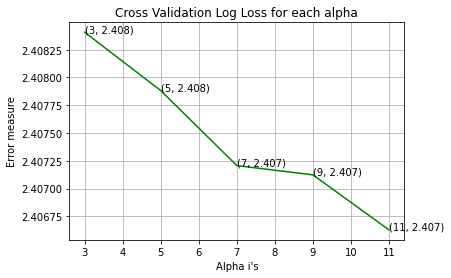

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, llKNNEVCv,c='g')
for i, txt in enumerate(np.round(llKNNEVCv,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],llKNNEVCv[i]))
plt.grid()
plt.title("Cross Validation Log Loss for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

## 2.3 Logistic Regression

In [ ]:
alpha = [10 ** x for x in range(-4, 3)]
llLREVTr=[]
llLREVCv=[]
for i in alpha:
    print("Working on Hyperparameter -", i)
    clfLR = LogisticRegression(C=i, class_weight='balanced', multi_class='multinomial',solver='lbfgs', n_jobs=-1)
    clfLR.fit(X_tr, y_train)
    print("--Running CalibratedClassifierCV")
    sig_clfLR = CalibratedClassifierCV(clfLR, method='sigmoid')
    sig_clfLR.fit(X_tr, y_train)
    y_pred = sig_clfLR.predict_proba(X_tr)
    llLREVTr.append(log_loss(y_train, y_pred, labels=clfLR.classes_))
    print('--Train Log Loss - ', log_loss(y_train, y_pred))
    y_pred = sig_clfLR.predict_proba(X_cr)
    llLREVCv.append(log_loss(y_cv, y_pred, labels=clfLR.classes_))
    print('--CV Log Loss - ', log_loss(y_cv, y_pred))

print("The best hyperparameter value is: ", alpha[np.argmin(llLREVCv)])

Working on Hyperparameter - 0.0001
--Running CalibratedClassifierCV
--Train Log Loss -  2.3917582186289077
--CV Log Loss -  2.3988880123356418
Working on Hyperparameter - 0.001
--Running CalibratedClassifierCV
--Train Log Loss -  2.376385702230857
--CV Log Loss -  2.387254596295587
Working on Hyperparameter - 0.01
--Running CalibratedClassifierCV
--Train Log Loss -  2.3698431043553985
--CV Log Loss -  2.3806134902688503
Working on Hyperparameter - 0.1
--Running CalibratedClassifierCV
--Train Log Loss -  2.3690258638040573
--CV Log Loss -  2.379898345392598
Working on Hyperparameter - 1
--Running CalibratedClassifierCV
--Train Log Loss -  2.3688860632170567
--CV Log Loss -  2.3798980831711627
Working on Hyperparameter - 10
--Running CalibratedClassifierCV
--Train Log Loss -  2.3688778904951002
--CV Log Loss -  2.3795801278453683
Working on Hyperparameter - 100
--Running CalibratedClassifierCV
--Train Log Loss -  2.3687341386441503
--CV Log Loss -  2.379565820077238
The best hyperparamet

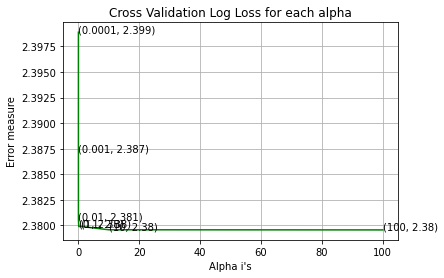

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, llLREVCv,c='g')
for i, txt in enumerate(np.round(llLREVCv,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],llLREVCv[i]))
plt.grid()
plt.title("Cross Validation Log Loss for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

## 2.4 Random Forest Classifier

In [ ]:
alpha = [10,50,100,250,500]
llRFEVTr = []
llRFEVCv = []
for i in alpha:
    print("Working on Hyperparameter -", i)
    clfRF = RandomForestClassifier(n_estimators=i, random_state=0, n_jobs=-1)
    clfRF.fit(X_tr, y_train)
    print("--Running CalibratedClassifierCV")
    sig_clfRF = CalibratedClassifierCV(clfRF, method='sigmoid')
    sig_clfRF.fit(X_tr, y_train)
    y_pred = sig_clfRF.predict_proba(X_tr)
    llRFEVTr.append(log_loss(y_train, y_pred, labels=clfRF.classes_))
    print('--Train Log Loss - ', log_loss(y_train, y_pred))
    y_pred = sig_clfRF.predict_proba(X_cr)
    llRFEVCv.append(log_loss(y_cv, y_pred, labels=clfRF.classes_))
    print('--CV Log Loss - ', log_loss(y_cv, y_pred))

print("The best hyperparameter value is: ", alpha[np.argmin(llRFEVCv)])

Working on Hyperparameter - 10
--Running CalibratedClassifierCV
--Train Log Loss -  1.237130046843937
--CV Log Loss -  2.2827712601998784
Working on Hyperparameter - 50
--Running CalibratedClassifierCV
--Train Log Loss -  0.6340461913373452
--CV Log Loss -  2.1735968485506225
Working on Hyperparameter - 100
--Running CalibratedClassifierCV
--Train Log Loss -  0.5563641149407095
--CV Log Loss -  2.1437976547954665
Working on Hyperparameter - 250
--Running CalibratedClassifierCV
--Train Log Loss -  0.4997603083922127
--CV Log Loss -  2.1164102157721043
Working on Hyperparameter - 500
--Running CalibratedClassifierCV
--Train Log Loss -  0.47845143169897797
--CV Log Loss -  2.10767024594322
The best hyperparameter value is:  500


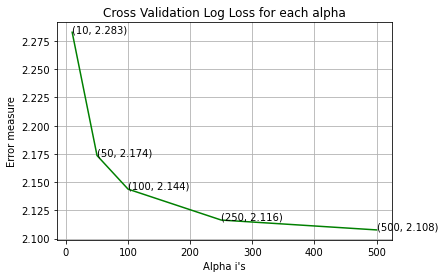

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, llRFEVCv,c='g')
for i, txt in enumerate(np.round(llRFEVCv,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],llRFEVCv[i]))
plt.grid()
plt.title("Cross Validation Log Loss for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

## 2.5 XGBoost Classifier

In [ ]:
alpha = [10, 25, 50, 75, 100, 200] 
llXGBEVTr = []
llXGBEVCv = []
for i in alpha:
    print("Working on Hyperparameter -", i)
    clfXGB = XGBClassifier(n_estimators=i, random_state=0, n_jobs=-1)
    clfXGB.fit(X_tr, y_train)
    print("--Running CalibratedClassifierCV")
    sig_clfXGB = CalibratedClassifierCV(clfXGB, method='sigmoid')
    sig_clfXGB.fit(X_tr, y_train)
    y_pred = clfXGB.predict_proba(X_tr)
    llXGBEVTr.append(log_loss(y_train, y_pred, labels=clfXGB.classes_))
    print('--Train Log Loss - ', log_loss(y_train, y_pred))
    y_pred = clfXGB.predict_proba(X_cr)
    llXGBEVCv.append(log_loss(y_cv, y_pred, labels=clfXGB.classes_))
    print('--CV Log Loss - ', log_loss(y_cv, y_pred))

print("The best hyperparameter value is: ", alpha[np.argmin(llXGBEVCv)])

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, llXGBEVCv,c='g')
for i, txt in enumerate(np.round(llXGBEVCv,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],llXGBEVCv[i]))
plt.grid()
plt.title("Cross Validation Log Loss for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
params = {}
params['booster'] = 'gblinear'
params['objective'] = "multi:softprob"
params['eval_metric'] = 'mlogloss'
params['eta'] = 0.1
params['num_class'] = 12
params['max_depth'] = 5
params['subsample'] = 0.5
params['nthread'] = -1
params['colsample_bytree'] = 0.3
params['lambda'] = 3
params['alpha'] = 2

d_train = xgb.DMatrix(X_tr, label=y_train, nthread=-1)
d_valid = xgb.DMatrix(X_cr, label=y_cv, nthread=-1)

watchlist = [(d_train, 'train'), (d_valid, 'eval')]

clf = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=25)

[0]	train-mlogloss:2.47666	eval-mlogloss:2.47667
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 25 rounds.
[1]	train-mlogloss:2.46939	eval-mlogloss:2.46941
[2]	train-mlogloss:2.46299	eval-mlogloss:2.46301
[3]	train-mlogloss:2.45732	eval-mlogloss:2.45735
[4]	train-mlogloss:2.4523	eval-mlogloss:2.45233
[5]	train-mlogloss:2.44782	eval-mlogloss:2.44786
[6]	train-mlogloss:2.44384	eval-mlogloss:2.44388
[7]	train-mlogloss:2.44029	eval-mlogloss:2.44034
[8]	train-mlogloss:2.43713	eval-mlogloss:2.43717
[9]	train-mlogloss:2.4343	eval-mlogloss:2.43435
[10]	train-mlogloss:2.43178	eval-mlogloss:2.43183
[11]	train-mlogloss:2.42952	eval-mlogloss:2.42958
[12]	train-mlogloss:2.4275	eval-mlogloss:2.42756
[13]	train-mlogloss:2.4257	eval-mlogloss:2.42576
[14]	train-mlogloss:2.42408	eval-mlogloss:2.42415
[15]	train-mlogloss:2.42264	eval-mlogloss:2.42271
[16]	train-mlogloss:2.42135	eval-mlogloss:2.42142
[17]	train-ml

## 2.6 LightGBM Classifier

In [ ]:
alpha = [10, 25, 50, 75, 100, 200] 
llLGBEVTr = []
llLGBEVCv = []
for i in alpha:
    print("Working on Hyperparameter -", i)
    clfLGB = LGBMClassifier(n_estimators=i, random_state=0, n_jobs=-1)
    clfLGB.fit(X_tr, y_train)
    print("--Running CalibratedClassifierCV")
    sig_clfLGB = CalibratedClassifierCV(clfLGB, method='sigmoid')
    sig_clfLGB.fit(X_tr, y_train)
    y_pred = clfLGB.predict_proba(X_tr)
    llLGBEVTr.append(log_loss(y_train, y_pred, labels=clfLGB.classes_))
    print('--Train Log Loss - ', log_loss(y_train, y_pred))
    y_pred = clfLGB.predict_proba(X_cr)
    llLGBEVCv.append(log_loss(y_cv, y_pred, labels=clfLGB.classes_))
    print('--CV Log Loss - ', log_loss(y_cv, y_pred))

print("The best hyperparameter value is: ", alpha[np.argmin(llLGBEVCv)])

Working on Hyperparameter - 10
--Running CalibratedClassifierCV
--Train Log Loss -  2.0400787092854724
--CV Log Loss -  2.2297947704759293
Working on Hyperparameter - 25
--Running CalibratedClassifierCV
--Train Log Loss -  1.7395292449856474
--CV Log Loss -  2.130319418226273
Working on Hyperparameter - 50
--Running CalibratedClassifierCV
--Train Log Loss -  1.409547007294805
--CV Log Loss -  2.0621872006923443
Working on Hyperparameter - 75
--Running CalibratedClassifierCV
--Train Log Loss -  1.183016346725949
--CV Log Loss -  2.0350063396466345
Working on Hyperparameter - 100
--Running CalibratedClassifierCV
--Train Log Loss -  1.014808347360679
--CV Log Loss -  2.0214201226220343
Working on Hyperparameter - 200
--Running CalibratedClassifierCV
--Train Log Loss -  0.6062157425287648
--CV Log Loss -  2.022247296067604
The best hyperparameter value is:  100


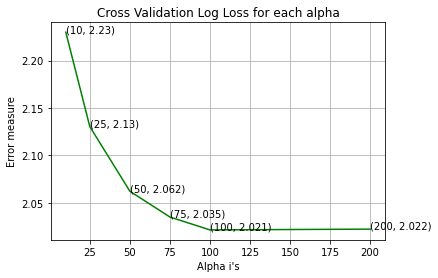

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, llLGBEVCv,c='g')
for i, txt in enumerate(np.round(llLGBEVCv,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],llLGBEVCv[i]))
plt.grid()
plt.title("Cross Validation Log Loss for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
import lightgbm as lgbm

print("--Setting the Parameters")
params = {}
params['boosting'] = 'gbdt'
params['objective'] = "multiclass"
params['metric'] = 'multi_logloss'
params['learning_rate'] = 0.1
params['num_class'] = 12
params['num_threads'] = -1
params['seed'] = 0
params['max_depth'] = 5
params['subsample'] = 0.5
params['colsample_bytree'] = 0.3

d_train = lgbm.Dataset(X_tr, label=y_train)
d_valid = lgbm.Dataset(X_cr, label=y_cv)
watchlist = [(d_train, 'train'), (d_valid, 'eval')]
print('--Training the model')
clf = lgbm.train(params, train_set=d_train, num_boost_round=1000,valid_sets=[d_train,d_valid], valid_names=['train','eval'], 
                 early_stopping_rounds=25)


--Setting the Parameters
--Training the model
[1]	train's multi_logloss: 2.36993	eval's multi_logloss: 2.38449
Training until validation scores don't improve for 25 rounds.
[2]	train's multi_logloss: 2.3331	eval's multi_logloss: 2.36335
[3]	train's multi_logloss: 2.30128	eval's multi_logloss: 2.34371
[4]	train's multi_logloss: 2.27072	eval's multi_logloss: 2.326
[5]	train's multi_logloss: 2.24275	eval's multi_logloss: 2.31125
[6]	train's multi_logloss: 2.21713	eval's multi_logloss: 2.29716
[7]	train's multi_logloss: 2.19465	eval's multi_logloss: 2.28453
[8]	train's multi_logloss: 2.1719	eval's multi_logloss: 2.27322
[9]	train's multi_logloss: 2.15042	eval's multi_logloss: 2.26215
[10]	train's multi_logloss: 2.13111	eval's multi_logloss: 2.25208
[11]	train's multi_logloss: 2.11275	eval's multi_logloss: 2.24287
[12]	train's multi_logloss: 2.0951	eval's multi_logloss: 2.23349
[13]	train's multi_logloss: 2.07831	eval's multi_logloss: 2.22503
[14]	train's multi_logloss: 2.06253	eval's multi

In [ ]:
print('--Predicting on the Train Data')
totalPred = clf.predict(X_tr)
llLGBEVTr = log_loss(y_train, totalPred)
print('----Train Log Loss on the EVENT Data:', llLGBEVTr)
print('--Predicting on the CV Data')
totalPred = clf.predict(X_cr)
llLGBEVCv = log_loss(y_cv, totalPred)
print('----Cross Validation Log Loss on the EVENT Data:', llLGBEVCv)

--Predicting on the Train Data
----Train Log Loss on the EVENT Data: 1.0782876208447156
--Predicting on the CV Data
----Cross Validation Log Loss on the EVENT Data: 2.0208742503913975


## 2.7 Neural Network Model

In [87]:
#---------------------------------------------------------------
# Defining CALLBACKS
#---------------------------------------------------------------
filepath = "model_save/weights-{epoch:02d}-{val_accuracy:.04f}.hdf5"
checkPoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='auto')

#logDir = 'logs'
#tensorBoard_callback = TensorBoard(log_dir=logDir, histogram_freq=1, write_graph=True)

earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                          verbose=1, mode='auto', restore_best_weights=True)

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                             patience=3, verbose=1, mode='auto')
callBacks = [reduceLR, earlyStop]

In [88]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

In [89]:
# REF - https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424
def evModel(input_dim, output_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(75, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=34)))
    model.add(PReLU(alpha_initializer="zeros"))
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=35)))
    model.add(PReLU(alpha_initializer="zeros"))
    model.add(Dropout(0.2))
    model.add(Dense(12, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=36)))

    model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
    
    return model

In [ ]:
eventModel = evModel(X_tr.shape[1], 12)
eventModel.summary()

In [ ]:
eventModel.fit(X_tr, y_train, batch_size=256, epochs=100, verbose=2, shuffle=True, validation_data=(X_cr, y_cv),callbacks=callBacks)

In [90]:
def eventsModel(shuffle):
    """
    Takes a list of Random Seeds, splits the data into Train and CV based on Seed, trains model and takes average of 
    predictions while testing  
    """
    model_list=[]
    loss_list=[]
    avg_cv_loss=0
    for i in range(len(shuffle)):
        print('--Iteration #', i)
        X_tr, X_cr, y_train, y_cv = train_test_split(Xev_tr, yev, stratify=yev, test_size=0.15, random_state=shuffle[i])
        y_train=np_utils.to_categorical(y_train)
        y_cv=np_utils.to_categorical(y_cv)
        model=evModel(X_tr.shape[1], 12)
        model.fit(X_tr, y_train, batch_size=256, epochs=100, verbose=2, shuffle=True, validation_data=(X_cr, y_cv),callbacks=callBacks)
        model.save('saved_models/noEvents/nn '+str(i+1))
        pred=model.predict(X_cr)
        cv_loss=log_loss(y_cv, pred)
        print("Validation Log Loss of  Model in Current Run: ", cv_loss)
        model_list.append(model)
        loss_list.append(cv_loss)
        avg_cv_loss = mean(loss_list)
        print("Average CV Loss of 6 Runs :", avg_cv_loss)
    return(model_list)

In [91]:
shuffle = [7, 14, 21, 28, 35, 42]
nnEvModel = eventsModel(shuffle)

--Iteration # 0
Epoch 1/100
78/78 - 1s - loss: 2.4326 - accuracy: 0.1341 - val_loss: 2.3915 - val_accuracy: 0.1498
Epoch 2/100
78/78 - 1s - loss: 2.3967 - accuracy: 0.1480 - val_loss: 2.3718 - val_accuracy: 0.1533
Epoch 3/100
78/78 - 1s - loss: 2.3755 - accuracy: 0.1616 - val_loss: 2.3477 - val_accuracy: 0.1756
Epoch 4/100
78/78 - 1s - loss: 2.3476 - accuracy: 0.1716 - val_loss: 2.3217 - val_accuracy: 0.1864
Epoch 5/100
78/78 - 1s - loss: 2.3167 - accuracy: 0.1898 - val_loss: 2.2890 - val_accuracy: 0.1925
Epoch 6/100
78/78 - 1s - loss: 2.2857 - accuracy: 0.1973 - val_loss: 2.2645 - val_accuracy: 0.2039
Epoch 7/100
78/78 - 1s - loss: 2.2600 - accuracy: 0.2076 - val_loss: 2.2372 - val_accuracy: 0.2096
Epoch 8/100
78/78 - 1s - loss: 2.2304 - accuracy: 0.2183 - val_loss: 2.2135 - val_accuracy: 0.2282
Epoch 9/100
78/78 - 1s - loss: 2.2059 - accuracy: 0.2294 - val_loss: 2.1872 - val_accuracy: 0.2411
Epoch 10/100
78/78 - 1s - loss: 2.1764 - accuracy: 0.2455 - val_loss: 2.1644 - val_accuracy: 

In [92]:
avg_pred=np.zeros((Xev_tr.shape[0],12))
for i in range(len(nnEvModel)):
    train_pred=nnEvModel[i].predict(Xev_tr)
    avg_pred+=train_pred
avg_pred/=len(nnEvModel)
print("Train Average Log-Loss: ",log_loss(yev, avg_pred))

Train Average Log-Loss:  1.706016315411962


In [93]:
avg_pred=np.zeros((Xev_cv.shape[0],12))
for i in range(len(nnEvModel)):
    cv_pred = nnEvModel[i].predict(Xev_cv)
    avg_pred += cv_pred
avg_pred/=len(nnEvModel)
print("CV Average Log-Loss: ", log_loss(yev_cv, avg_pred))

CV Average Log-Loss:  1.6868781342616384


In [94]:
predEv=np.zeros((Xev_te.shape[0],12))
for i in range(len(nnEvModel)):
    te_pred = nnEvModel[i].predict(Xev_te)
    predEv += te_pred
predEv/=len(nnEvModel)

In [ ]:
pred = evModel.predict(X_tr)
llNNEVTr=log_loss(y_train, pred)
print("Training Log Loss of NN Model: ",llNNEVTr)
pred = evModel.predict(X_cr)
llNNEVCv=log_loss(y_cv, pred)
print("Validation Log Loss of NN Model: ",llNNEVCv)

In [ ]:
predEv = eventModel.predict(X_te)

In [ ]:
X_test = testEventData.reset_index(drop=True)
predEvent = pd.DataFrame(predEv, columns=oheev.classes_)
print(predEvent.shape)
predEvent = pd.concat([X_test.device_id, predEvent], axis=1, ignore_index=True)
finalCols = np.append('device_id', oheev.classes_)
predEvent.columns = [finalCols]
print(predEvent.shape)
predEvent.head()

#### Here, we can observe that for Dataset with 'Events Data', Neural Network has given MINIMUM LOG-LOSS results.
#### Hence, we will use Neural Network for final modelling

In [105]:
Result = PrettyTable()
Result.field_names = ["Model", "Data", "Train Loss", "CV Loss"]
Result.add_row(["Random", "With Events", "2.484906649788001", "2.4849066497880004"])
Result.add_row(["K-Nearest Neighbor", "With Events", "2.405654255269296", "2.4102048713798823"]) #np.min(llKNNEVTr), np.min(llKNNEVCv)])
Result.add_row(["Logistic Regression", "With Events", "2.3687341386441503", "2.379565820077238"]) #np.min(llLREVTr), np.min(llLREVCv)])
Result.add_row(["Random Forest", "With Events", "0.47845143169897797", "2.10767024594322"]) #np.min(llRFEVTr), np.min(llRFEVCv)])
Result.add_row(["XGBoost", "With Events", "0.6436960138144913", "2.110022073399063"]) #np.min(llXGBEVTr), np.min(llXGBEVCv)])
Result.add_row(["lightGBM", "With Events", "1.0782876208447156", "2.0208742503913975"]) #np.min(llLGBEVTr), np.min(llLGBEVCv)])
Result.add_row(["Neural Network", "With Events", "1.706016315411962", "1.6868781342616384"]) #llNNEVTr, llNNEVCv])

print(Result)

+---------------------+-------------+---------------------+--------------------+
|        Model        |     Data    |      Train Loss     |      CV Loss       |
+---------------------+-------------+---------------------+--------------------+
|        Random       | With Events |  2.484906649788001  | 2.4849066497880004 |
|  K-Nearest Neighbor | With Events |  2.405654255269296  | 2.4102048713798823 |
| Logistic Regression | With Events |  2.3687341386441503 | 2.379565820077238  |
|    Random Forest    | With Events | 0.47845143169897797 |  2.10767024594322  |
|       XGBoost       | With Events |  0.6436960138144913 | 2.110022073399063  |
|       lightGBM      | With Events |  1.0782876208447156 | 2.0208742503913975 |
|    Neural Network   | With Events |  1.706016315411962  | 1.6868781342616384 |
+---------------------+-------------+---------------------+--------------------+


# 3. Working on Data with NO-Events¶

## 3.1 Reading the PICKLE File

In [ ]:
with open('noEventtrainData', 'rb') as fp:
    X_tr = pickle.load(fp)
with open('noEventCVData', 'rb') as fp:
    X_cr = pickle.load(fp)
with open('noEventtestData', 'rb') as fp:
    X_te = pickle.load(fp)
with open('noEventytrain', 'rb') as fp:
    y_train = pickle.load(fp)
with open('noEventycv', 'rb') as fp:
    y_cv = pickle.load(fp)
    
print("====================================")
print("After Loading PICKLE Files ")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape)
print("====================================")

After Loading PICKLE Files 
(59716, 1535) (59716,)
(14929, 1535) (14929,)
(112071, 1535)


In [96]:
with open('Xnoev_tr', 'rb') as fp:
    Xnoev_tr = pickle.load(fp)
with open('Xnoev_te', 'rb') as fp:
    Xnoev_te = pickle.load(fp)
with open('ynoev', 'rb') as fp:
    ynoev = pickle.load(fp)
    
print("====================================")
print("After Loading PICKLE Files ")
print(Xnoev_tr.shape, ynoev.shape)
print(Xnoev_te.shape)
print("====================================")

After Loading PICKLE Files 
(74645, 1701) (74645,)
(76877, 1701)


## 3.2 Trying Different Models for the Performance

### 3.2.1 Random Model
A random model is something that will give us worst possible results. So, let's say, our model predicts '1' probability for all. Log Loss in such case would be

In [ ]:
y_pred = [[1]*12]*y_train.shape[0]
logLoss = log_loss(y_train, y_pred)
print("Train Loss:", logLoss)

y_pred = [[1]*12]*y_cv.shape[0]
logLoss = log_loss(y_cv, y_pred)
print("Cross Validation Loss:", logLoss)

Train Loss: 2.4849066497880012
Cross Validation Loss: 2.484906649788001


Thus, the <b>worst LOG LOSS</b> that we can get is <b>'2.484906649788001'</b> <br>
Our model should give much better results than this.

### 3.2.2 K-Nearest Neighbor

In [ ]:
alpha = [x for x in range(3, 11, 2)]
llKNNnoEVTr=[]
llKNNnoEVCv=[]
for i in alpha:
    print("Working on Hyperparameter -", i)
    clfKNN = KNeighborsClassifier(n_neighbors=i)
    clfKNN.fit(X_tr, y_train)
    print("--Running CalibratedClassifierCV")
    sig_clfKNN = CalibratedClassifierCV(clfKNN, method='sigmoid')
    sig_clfKNN.fit(X_tr, y_train)
    y_pred = sig_clfKNN.predict_proba(X_tr)
    llKNNnoEVTr.append(log_loss(y_train, y_pred, labels=clfKNN.classes_))
    print('--Train Log Loss - ', log_loss(y_train, y_pred))
    y_pred = sig_clfKNN.predict_proba(X_cr)
    llKNNnoEVCv.append(log_loss(y_cv, y_pred, labels=clfKNN.classes_))
    print('--CV Log Loss - ', log_loss(y_cv, y_pred))
    
print("The best hyperparameter value is: ", alpha[np.argmin(llKNNnoEVCv)])

Working on Hyperparameter - 3
--Running CalibratedClassifierCV
--Train Log Loss -  2.4180862781440995
--CV Log Loss -  2.427226372509495
Working on Hyperparameter - 5
--Running CalibratedClassifierCV
--Train Log Loss -  2.4071128806837225
--CV Log Loss -  2.4211226843243394
Working on Hyperparameter - 7
--Running CalibratedClassifierCV
--Train Log Loss -  2.4028747800113153
--CV Log Loss -  2.4193541073597316
Working on Hyperparameter - 9
--Running CalibratedClassifierCV
--Train Log Loss -  2.3995838285708935
--CV Log Loss -  2.4179643888665745
The best hyperparameter value is:  9


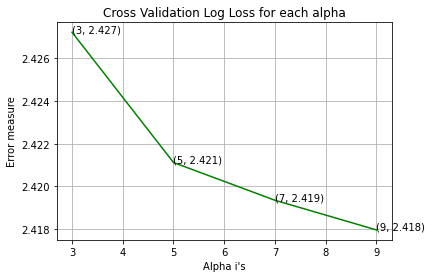

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, llKNNnoEVCv,c='g')
for i, txt in enumerate(np.round(llKNNnoEVCv,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],llKNNnoEVCv[i]))
plt.grid()
plt.title("Cross Validation Log Loss for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

### 3.2.3 Logistic Regression

In [ ]:
alpha = [10 ** x for x in range(-5, 4)]
llLRnoEVTr=[]
llLRnoEVCv=[]
for i in alpha:
    print("Working on Hyperparameter -", i)
    clfLR = LogisticRegression(C=i, class_weight='balanced', multi_class='multinomial',solver='lbfgs', n_jobs=-1)
    clfLR.fit(X_tr, y_train)
    print("--Running CalibratedClassifierCV")
    sig_clfLR = CalibratedClassifierCV(clfLR, method='sigmoid')
    sig_clfLR.fit(X_tr, y_train)
    y_pred = sig_clfLR.predict_proba(X_tr)
    llLRnoEVTr.append(log_loss(y_train, y_pred, labels=clfLR.classes_))
    print('--Train Log Loss - ', log_loss(y_train, y_pred))
    y_pred = sig_clfLR.predict_proba(X_cr)
    llLRnoEVCv.append(log_loss(y_cv, y_pred, labels=clfLR.classes_))
    print('--CV Log Loss - ', log_loss(y_cv, y_pred))

print("The best hyperparameter value is: ", alpha[np.argmin(llLRnoEVCv)])

Working on Hyperparameter - 1e-05
--Running CalibratedClassifierCV
--Train Log Loss -  2.4097150709256505
--CV Log Loss -  2.409641539200608
Working on Hyperparameter - 0.0001
--Running CalibratedClassifierCV
--Train Log Loss -  2.4093163920726557
--CV Log Loss -  2.409349491940956
Working on Hyperparameter - 0.001
--Running CalibratedClassifierCV
--Train Log Loss -  2.4063465162933935
--CV Log Loss -  2.4073500556147915
Working on Hyperparameter - 0.01
--Running CalibratedClassifierCV
--Train Log Loss -  2.395402737439753
--CV Log Loss -  2.4024386496088654
Working on Hyperparameter - 0.1
--Running CalibratedClassifierCV
--Train Log Loss -  2.3689493058556725
--CV Log Loss -  2.3969800630889164
Working on Hyperparameter - 1
--Running CalibratedClassifierCV
--Train Log Loss -  2.34232800739924
--CV Log Loss -  2.3971477658180236
Working on Hyperparameter - 10
--Running CalibratedClassifierCV
--Train Log Loss -  2.34757843012528
--CV Log Loss -  2.403920984252479
Working on Hyperparamet

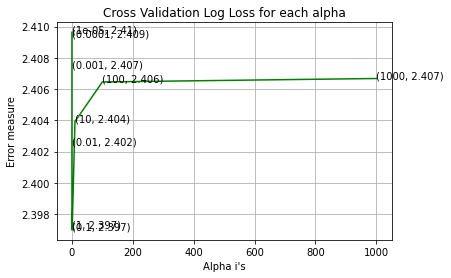

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, llLRnoEVCv,c='g')
for i, txt in enumerate(np.round(llLRnoEVCv,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],llLRnoEVCv[i]))
plt.grid()
plt.title("Cross Validation Log Loss for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

### 3.2.4 Random Forest

In [ ]:
alpha = [10,25,50,100,250,300]
llRFnoEVTr = []
llRFnoEVCv = []
for i in alpha:
    print("Working on Hyperparameter -", i)
    clfRF = RandomForestClassifier(n_estimators=i, random_state=0, n_jobs=-1)
    clfRF.fit(X_tr, y_train)
    print("--Running CalibratedClassifierCV")
    sig_clfRF = CalibratedClassifierCV(clfRF, method='sigmoid')
    sig_clfRF.fit(X_tr, y_train)
    y_pred = sig_clfRF.predict_proba(X_tr)
    llRFnoEVTr.append(log_loss(y_train, y_pred, labels=clfRF.classes_))
    print('--Train Log Loss - ', log_loss(y_train, y_pred))
    y_pred = sig_clfRF.predict_proba(X_cr)
    llRFnoEVCv.append(log_loss(y_cv, y_pred, labels=clfRF.classes_))
    print('--CV Log Loss - ', log_loss(y_cv, y_pred))

print("The best hyperparameter value is: ", alpha[np.argmin(llRFnoEVCv)])

Working on Hyperparameter - 10
--Running CalibratedClassifierCV
--Train Log Loss -  2.348774646350755
--CV Log Loss -  2.409598224663675
Working on Hyperparameter - 25
--Running CalibratedClassifierCV
--Train Log Loss -  2.3453998915018044
--CV Log Loss -  2.408669749439918
Working on Hyperparameter - 50
--Running CalibratedClassifierCV
--Train Log Loss -  2.3442040760416005
--CV Log Loss -  2.4086007818119035
Working on Hyperparameter - 100
--Running CalibratedClassifierCV
--Train Log Loss -  2.343405836584301
--CV Log Loss -  2.408402213417766
Working on Hyperparameter - 250
--Running CalibratedClassifierCV
--Train Log Loss -  2.3430906488775842
--CV Log Loss -  2.4081990526514327
Working on Hyperparameter - 300
--Running CalibratedClassifierCV
--Train Log Loss -  2.343125122926379
--CV Log Loss -  2.40820230272212
The best hyperparameter value is:  250


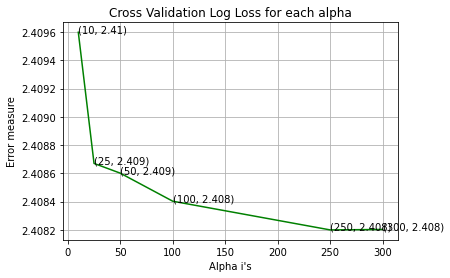

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, llRFnoEVCv,c='g')
for i, txt in enumerate(np.round(llRFnoEVCv,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],llRFnoEVCv[i]))
plt.grid()
plt.title("Cross Validation Log Loss for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

### 3.2.5 XGBoost

In [ ]:
alpha = [10, 25, 50, 75, 100, 200] #[10,12,15,17,20,22,25,30,50,60,75]
llXGBnoEVTr = []
llXGBnoEVCv = []
for i in alpha:
    print("Working on Hyperparameter -", i)
    clfXGB = XGBClassifier(n_estimators=i, random_state=0, n_jobs=-1)
    clfXGB.fit(X_tr, y_train)
    print("--Running CalibratedClassifierCV")
    sig_clfXGB = CalibratedClassifierCV(clfXGB, method='sigmoid')
    sig_clfXGB.fit(X_tr, y_train)
    y_pred = clfXGB.predict_proba(X_tr)
    llXGBnoEVTr.append(log_loss(y_train, y_pred, labels=clfXGB.classes_))
    print('--Train Log Loss - ', log_loss(y_train, y_pred))
    y_pred = clfXGB.predict_proba(X_cr)
    llXGBnoEVCv.append(log_loss(y_cv, y_pred, labels=clfXGB.classes_))
    print('--CV Log Loss - ', log_loss(y_cv, y_pred))

print("The best hyperparameter value is: ", alpha[np.argmin(llXGBnoEVCv)])

Working on Hyperparameter - 10
--Running CalibratedClassifierCV
--Train Log Loss -  2.3813233497971926
--CV Log Loss -  2.403788589263269
Working on Hyperparameter - 25
--Running CalibratedClassifierCV
--Train Log Loss -  2.36107984969754
--CV Log Loss -  2.399536344580814
Working on Hyperparameter - 50
--Running CalibratedClassifierCV
--Train Log Loss -  2.3442259820554963
--CV Log Loss -  2.3988192207359553
Working on Hyperparameter - 75
--Running CalibratedClassifierCV
--Train Log Loss -  2.332954409059739
--CV Log Loss -  2.3999577957627416
Working on Hyperparameter - 100
--Running CalibratedClassifierCV
--Train Log Loss -  2.324460398200785
--CV Log Loss -  2.4016036941881396
Working on Hyperparameter - 200
--Running CalibratedClassifierCV
--Train Log Loss -  2.302921355757951
--CV Log Loss -  2.4098855437958315
The best hyperparameter value is:  50


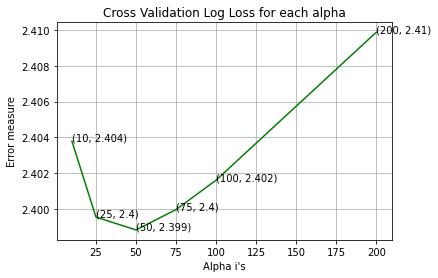

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, llXGBnoEVCv,c='g')
for i, txt in enumerate(np.round(llXGBnoEVCv,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],llXGBnoEVCv[i]))
plt.grid()
plt.title("Cross Validation Log Loss for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

### 3.2.6 LightGBM

In [ ]:
alpha = [10, 25, 50, 75, 100, 200] #[10,12,15,17,20,22,25,30,50,60,75]
llLGBnoEVTr = []
llLGBnoEVCv = []
for i in alpha:
    print("Working on Hyperparameter -", i)
    clfLGB = LGBMClassifier(n_estimators=i, random_state=0, n_jobs=-1)
    clfLGB.fit(X_tr, y_train)
    print("--Running CalibratedClassifierCV")
    sig_clfLGB = CalibratedClassifierCV(clfLGB, method='sigmoid')
    sig_clfLGB.fit(X_tr, y_train)
    y_pred = clfLGB.predict_proba(X_tr)
    llLGBnoEVTr.append(log_loss(y_train, y_pred, labels=clfLGB.classes_))
    print('--Train Log Loss - ', log_loss(y_train, y_pred))
    y_pred = clfLGB.predict_proba(X_cr)
    llLGBnoEVCv.append(log_loss(y_cv, y_pred, labels=clfLGB.classes_))
    print('--CV Log Loss - ', log_loss(y_cv, y_pred))

print("The best hyperparameter value is: ", alpha[np.argmin(llLGBnoEVCv)])

Working on Hyperparameter - 10
--Running CalibratedClassifierCV
--Train Log Loss -  2.390554152874451
--CV Log Loss -  2.4085923663465447
Working on Hyperparameter - 25
--Running CalibratedClassifierCV
--Train Log Loss -  2.367397202176114
--CV Log Loss -  2.4003797197881362
Working on Hyperparameter - 50
--Running CalibratedClassifierCV
--Train Log Loss -  2.349643708694307
--CV Log Loss -  2.4001542093656267
Working on Hyperparameter - 75
--Running CalibratedClassifierCV
--Train Log Loss -  2.3387415992886864
--CV Log Loss -  2.4037732473264626
Working on Hyperparameter - 100
--Running CalibratedClassifierCV
--Train Log Loss -  2.3306298027618872
--CV Log Loss -  2.4081991369333946
Working on Hyperparameter - 200
--Running CalibratedClassifierCV
--Train Log Loss -  2.3113982503652104
--CV Log Loss -  2.427396340191008
The best hyperparameter value is:  50


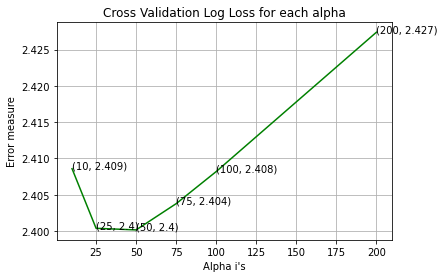

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, llLGBnoEVCv,c='g')
for i, txt in enumerate(np.round(llLGBnoEVCv,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],llLGBnoEVCv[i]))
plt.grid()
plt.title("Cross Validation Log Loss for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
import lightgbm as lgbm

print("--Setting the Parameters")
params = {}
params['boosting'] = 'gbdt'
params['objective'] = "multiclass"
params['metric'] = 'multi_logloss'
params['learning_rate'] = 0.1
params['num_class'] = 12
params['num_threads'] = -1
params['seed'] = 0
params['max_depth'] = 5
params['subsample'] = 0.5
params['colsample_bytree'] = 0.3

d_train = lgbm.Dataset(X_tr, label=y_train)
d_valid = lgbm.Dataset(X_cr, label=y_cv)
watchlist = [(d_train, 'train'), (d_valid, 'eval')]
print('--Training the model')
clf = lgbm.train(params, train_set=d_train, num_boost_round=1000,valid_sets=[d_train,d_valid], valid_names=['train','eval'], 
                 early_stopping_rounds=25)

--Setting the Parameters
--Training the model
[1]	train's multi_logloss: 2.4285	eval's multi_logloss: 2.42937
Training until validation scores don't improve for 25 rounds.
[2]	train's multi_logloss: 2.42592	eval's multi_logloss: 2.42765
[3]	train's multi_logloss: 2.42348	eval's multi_logloss: 2.42588
[4]	train's multi_logloss: 2.42098	eval's multi_logloss: 2.42401
[5]	train's multi_logloss: 2.41909	eval's multi_logloss: 2.42283
[6]	train's multi_logloss: 2.41688	eval's multi_logloss: 2.4213
[7]	train's multi_logloss: 2.41518	eval's multi_logloss: 2.42018
[8]	train's multi_logloss: 2.41347	eval's multi_logloss: 2.41905
[9]	train's multi_logloss: 2.41181	eval's multi_logloss: 2.4178
[10]	train's multi_logloss: 2.41055	eval's multi_logloss: 2.41708
[11]	train's multi_logloss: 2.40924	eval's multi_logloss: 2.41629
[12]	train's multi_logloss: 2.40783	eval's multi_logloss: 2.41538
[13]	train's multi_logloss: 2.40663	eval's multi_logloss: 2.41468
[14]	train's multi_logloss: 2.40539	eval's mul

In [ ]:
print('--Predicting on the Train Data')
totalPred = clf.predict(X_tr)
llLGBnoEVTr = log_loss(y_train, totalPred)
print('----Train Log Loss on the EVENT Data:', llLGBnoEVTr)
print('--Predicting on the CV Data')
totalPred = clf.predict(X_cr)
llLGBnoEVTr = log_loss(y_cv, totalPred)
print('----Cross Validation Log Loss on the EVENT Data:', llLGBnoEVTr)

--Predicting on the Train Data
----Train Log Loss on the EVENT Data: 2.36290300767602
--Predicting on the CV Data
----Cross Validation Log Loss on the EVENT Data: 2.399103267052951


### 3.2.7 Neural Network

In [97]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()

In [98]:
def noEvModel(input_dim, output_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(256, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=44)))
    model.add(PReLU(alpha_initializer="zeros"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(12, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=46)))
    
    model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
    
    return model

In [ ]:
#noEventModel = noEvModel(X_tr.shape[1], 12)
noEventModel.summary()

In [99]:
def noEventsModel(shuffle):
    """
    Takes a list of Random Seeds, splits the data into Train and CV based on Seed, trains model and takes average of 
    predictions while testing  
    """
    model_list=[]
    loss_list=[]
    avg_cv_loss=0
    for i in range(len(shuffle)):
        print('--Iteration #', i)
        X_tr, X_cr, y_train, y_cv = train_test_split(Xnoev_tr, ynoev, stratify=ynoev, test_size=0.15, random_state=shuffle[i])
        y_train=np_utils.to_categorical(y_train)
        y_cv=np_utils.to_categorical(y_cv)
        model=noEvModel(X_tr.shape[1], 12)
        model.fit(X_tr, y_train, batch_size=256, epochs=100, verbose=2, shuffle=True, validation_data=(X_cr, y_cv),callbacks=callBacks)
        model.save('saved_models/noEvents/nn '+str(i+1))
        pred=model.predict(X_cr)
        cv_loss=log_loss(y_cv, pred)
        print("Validation Log Loss of  Model in Current Run: ", cv_loss)
        model_list.append(model)
        loss_list.append(cv_loss)
    avg_cv_loss = mean(loss_list)
    print("Average CV Loss of 6 Runs :", avg_cv_loss)
    return(model_list)

In [100]:
shuffle = [7, 14, 21, 28, 35, 42]
nnNoEvModel = noEventsModel(shuffle)

--Iteration # 0
Epoch 1/100
248/248 - 1s - loss: 2.6043 - accuracy: 0.1152 - val_loss: 2.4229 - val_accuracy: 0.1422
Epoch 2/100
248/248 - 1s - loss: 2.4278 - accuracy: 0.1456 - val_loss: 2.4103 - val_accuracy: 0.1462
Epoch 3/100
248/248 - 1s - loss: 2.3995 - accuracy: 0.1513 - val_loss: 2.3980 - val_accuracy: 0.1519
Epoch 4/100
248/248 - 1s - loss: 2.3870 - accuracy: 0.1581 - val_loss: 2.3956 - val_accuracy: 0.1549
Epoch 5/100
248/248 - 1s - loss: 2.3772 - accuracy: 0.1612 - val_loss: 2.3952 - val_accuracy: 0.1567
Epoch 6/100
248/248 - 1s - loss: 2.3718 - accuracy: 0.1631 - val_loss: 2.3953 - val_accuracy: 0.1554
Epoch 7/100
248/248 - 1s - loss: 2.3671 - accuracy: 0.1659 - val_loss: 2.3944 - val_accuracy: 0.1540
Epoch 8/100
248/248 - 1s - loss: 2.3628 - accuracy: 0.1679 - val_loss: 2.3964 - val_accuracy: 0.1588
Epoch 9/100
248/248 - 1s - loss: 2.3577 - accuracy: 0.1687 - val_loss: 2.3965 - val_accuracy: 0.1602
Epoch 10/100

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00

In [101]:
avg_pred=np.zeros((Xnoev_tr.shape[0],12))
for i in range(len(nnNoEvModel)):
    train_pred=nnNoEvModel[i].predict(Xnoev_tr)
    avg_pred+=train_pred
avg_pred/=len(nnNoEvModel)
print("Train Average Log-Loss: ",log_loss(ynoev, avg_pred))

Train Average Log-Loss:  2.349539449164375


In [102]:
avg_pred=np.zeros((Xnoev_cv.shape[0],12))
for i in range(len(nnNoEvModel)):
    cv_pred = nnNoEvModel[i].predict(Xnoev_cv)
    avg_pred += cv_pred
avg_pred/=len(nnNoEvModel)
print("CV Average Log-Loss: ",log_loss(ynoev_cv, avg_pred))

CV Average Log-Loss:  2.3458688568511508


In [103]:
prednoEv=np.zeros((Xnoev_te.shape[0],12))
for i in range(len(nnNoEvModel)):
    te_pred = nnNoEvModel[i].predict(Xnoev_te)
    prednoEv += te_pred
prednoEv/=len(nnNoEvModel)

In [ ]:
pred = noEventModel.predict(X_tr)
llNNnoEVTr=log_loss(y_train, pred)
print("Training Log Loss of NN Model: ",llNNnoEVTr)
pred = noEventModel.predict(X_cr)
llNNnoEVCv=log_loss(y_cv, pred)
print("Validation Log Loss of NN Model: ",llNNnoEVCv)

Training Log Loss of NN Model:  2.354636035159393
Validation Log Loss of NN Model:  2.3875050213158238


In [ ]:
prednoEv = noEventModel.predict(X_te)

In [ ]:
X_test = notestEventData.reset_index(drop=True)
prednoEv = pd.DataFrame(prednoEv, columns=ohenoev.classes_)
print(prednoEv.shape)
prednoEv = pd.concat([X_test.device_id, prednoEv], axis=1, ignore_index=True)
finalCols = np.append('device_id', ohenoev.classes_)
prednoEv.columns = [finalCols]
print(prednoEv.shape)
prednoEv.head()

In [ ]:
predTotal = pd.concat([predEvent, prednoEv], ignore_index=True)
predTotal.to_csv('prediction_total_data.zip', compression='zip', index=False)
print(predTotal.shape)
predTotal.head()

### 3.2.8 Comparing the Model Performance

In [106]:
#Result = PrettyTable()
#Result.field_names = ["Model", "Data", "Train Loss", "CV Loss"]
Result.add_row(["Random", "No Events", "2.4849066497880012", "2.484906649788001"])
Result.add_row(["K-Nearest Neighbor", "No Events", "2.3995838285708935", "2.4179643888665745"]) #np.min(llKNNnoEVTr), np.min(llKNNnoEVCv)])
Result.add_row(["Logistic Regression", "No Events", "2.34232800739924", "2.3969800630889164"]) #np.min(llLRnoEVTr), np.min(llLRnoEVCv)])
Result.add_row(["Random Forest", "No Events", "2.3430906488775842", "2.4081990526514327"]) #np.min(llRFnoEVTr), np.min(llRFnoEVCv)])
Result.add_row(["XGBoost", "No Events", "2.3442259820554963", "2.3988192207359553"]) #np.min(llXGBnoEVTr), np.min(llXGBnoEVCv)])
Result.add_row(["lightGBM", "No Events", "2.36290300767602", "2.399103267052951"]) #np.min(llLGBnoEVTr), np.min(llLGBnoEVCv)])
Result.add_row(["Neural Network", "No Events", "2.349539449164375", "2.3458688568511508"]) #llNNnoEVTr, np.min(llNNnoEVCv)])

print(Result)

+---------------------+-------------+---------------------+--------------------+
|        Model        |     Data    |      Train Loss     |      CV Loss       |
+---------------------+-------------+---------------------+--------------------+
|        Random       | With Events |  2.484906649788001  | 2.4849066497880004 |
|  K-Nearest Neighbor | With Events |  2.405654255269296  | 2.4102048713798823 |
| Logistic Regression | With Events |  2.3687341386441503 | 2.379565820077238  |
|    Random Forest    | With Events | 0.47845143169897797 |  2.10767024594322  |
|       XGBoost       | With Events |  0.6436960138144913 | 2.110022073399063  |
|       lightGBM      | With Events |  1.0782876208447156 | 2.0208742503913975 |
|    Neural Network   | With Events |  1.706016315411962  | 1.6868781342616384 |
|        Random       |  No Events  |  2.4849066497880012 | 2.484906649788001  |
|  K-Nearest Neighbor |  No Events  |  2.3995838285708935 | 2.4179643888665745 |
| Logistic Regression |  No 

#### Here, we can observe that for Dataset with 'No Events Data', Neural Network has given MINIMUM LOG-LOSS results.
#### Hence, we will use Neural Network for final modelling